# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
!pip install progressbar

  Running setup.py bdist_wheel for progressbar ... done
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built progressbar


In [2]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
import progressbar
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
import cv2
% matplotlib inline

In [3]:
!python --version

Python 3.6.3


In [4]:
print("pandas version: " + pd.__version__)
print("\n")
print("matplotlib version: 2.1.0")
print("\n")
print("numpy version: " + np.__version__)
print("\n")
# print("datetime version: " + datetime.__version__)
# print("\n")
print("json version: " + json.__version__)
print("\n")
print("math version: 1.0.0")

pandas version: 0.23.3


matplotlib version: 2.1.0


numpy version: 1.12.1


json version: 2.0.9


math version: 1.0.0


In [5]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [6]:
# portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)

# Data Cleaning

## Transcript

In [7]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [8]:
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [9]:
keys = set()
for i in range(transcript.shape[0]):  
    k = list(transcript['value'].values[i].keys())
    n_k = len(k)
    for j in range(n_k):
        keys.add(k[j])
keys

{'amount', 'offer id', 'offer_id', 'reward'}

In [10]:
keys = list(keys)

In [11]:
def get_key_values(df, col):
    k = df[col].values[0].keys()
    v = df[col].values[0].values()
    return k, v

In [12]:
for key in keys:
    transcript[key] = transcript["value"].apply(lambda k: k[key] if key in k else 0)
transcript.head()

,event,person,time,value,amount,offer id,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0.0,2906b810c7d4411798c6938adc9daaa5,0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0.0,fafdcd668e3743c1bb461111dcafc2a4,0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0


In [13]:
transcript['portfolio_id'] = transcript.apply(lambda x: x['offer id'] if x['offer id'] != 0 else x['offer_id'], axis = 1)

In [14]:
transcript = transcript.drop(['offer id', 'offer_id', 'value'], axis = 1)

In [15]:
transcript = transcript.rename(columns = {'person':'customer_id'})

In [16]:
transcript.head()

,event,customer_id,time,amount,reward,portfolio_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,0.0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0.0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,0.0,0,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,0.0,0,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,0.0,0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [17]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

## Portfolio

In [18]:
portfolio = portfolio.rename(columns ={'id':'portfolio_id'})

In [19]:
portfolio.head()

,channels,difficulty,duration,portfolio_id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [20]:
portfolio.isnull().sum()

channels        0
difficulty      0
duration        0
portfolio_id    0
offer_type      0
reward          0
dtype: int64

In [21]:
portfolio['channels']

0         [email, mobile, social]
1    [web, email, mobile, social]
2            [web, email, mobile]
3            [web, email, mobile]
4                    [web, email]
5    [web, email, mobile, social]
6    [web, email, mobile, social]
7         [email, mobile, social]
8    [web, email, mobile, social]
9            [web, email, mobile]
Name: channels, dtype: object

In [22]:
channels = portfolio['channels'].max()
channels

['web', 'email', 'mobile', 'social']

In [23]:
for channel in channels:
    portfolio['channel_' + channel] = portfolio.apply(lambda x: 1 if channel in x['channels'] else 0, axis = 1)

In [24]:
portfolio.head()

,channels,difficulty,duration,portfolio_id,offer_type,reward,channel_web,channel_email,channel_mobile,channel_social
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0


In [25]:
portfolio = portfolio.drop(['channels'], axis = 1)

In [401]:
portfolio["offer_name"] = "offer_"+portfolio.index.astype(str)

In [26]:
portfolio.head()

,difficulty,duration,portfolio_id,offer_type,reward,channel_web,channel_email,channel_mobile,channel_social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0


## Profile

In [27]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [28]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [29]:
profile = profile.rename(columns={'id':'customer_id'})

In [30]:
profile['became_member_on'] = profile.apply(lambda x: pd.to_datetime(str(x['became_member_on']), format='%Y%m%d'), axis = 1)

In [31]:
profile['days_since_member'] = (pd.to_datetime("today") - profile['became_member_on']).dt.days

In [32]:
profile['age'].describe()

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

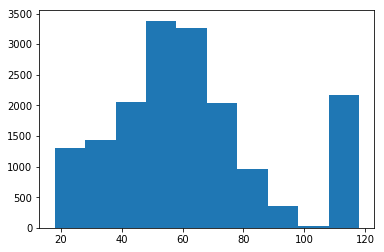

In [33]:
plt.hist(profile['age'])
plt.show()

In [34]:
profile.loc[profile['age'] == 118, 'age'] = np.nan

In [35]:
profile.loc[~profile["age"].isnull(), "age"].describe()

count    14825.000000
mean        54.393524
std         17.383705
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64

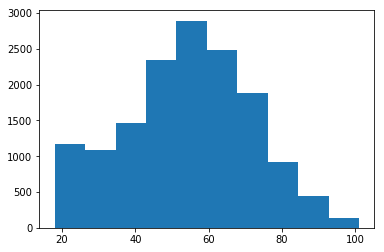

In [36]:
plt.hist(profile.loc[~profile["age"].isnull(), "age"])
plt.show()

In [37]:
age_5_pct = np.percentile(profile.loc[~profile["age"].isnull(), "age"], 5)
age_85_pct = np.percentile(profile.loc[~profile["age"].isnull(), "age"], 85)

In [38]:
profile['age'] = profile['age'].fillna(np.random.randint(age_5_pct, age_85_pct, 1)[0])

In [39]:
profile['age'].describe()

count    17000.000000
mean        55.238765
std         16.382854
min         18.000000
25%         45.000000
50%         58.000000
75%         65.000000
max        101.000000
Name: age, dtype: float64

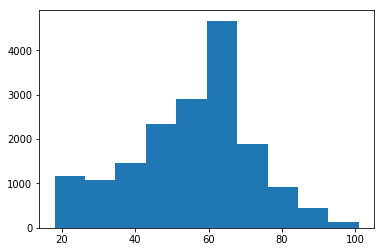

In [40]:
plt.hist(profile['age'])
plt.show()

# Exploratory Analysis

## Portfolio

In [41]:
portfolio.head()

,difficulty,duration,portfolio_id,offer_type,reward,channel_web,channel_email,channel_mobile,channel_social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0


In [42]:
len(portfolio["portfolio_id"].unique())

10

In [43]:
portfolio["offer_type"].unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [44]:
portfolio.groupby("offer_type")["portfolio_id"].count()

offer_type
bogo             4
discount         4
informational    2
Name: portfolio_id, dtype: int64

In [45]:
portfolio.groupby("offer_type")[["channel_web", "channel_email", "channel_mobile", "channel_social"]].sum()

,channel_web,channel_email,channel_mobile,channel_social
offer_type,,,,
bogo,3,4,4,3
discount,4,4,3,2
informational,1,2,2,1


In [46]:
portfolio["difficulty"].describe()

count    10.000000
mean      7.700000
std       5.831905
min       0.000000
25%       5.000000
50%       8.500000
75%      10.000000
max      20.000000
Name: difficulty, dtype: float64

In [47]:
portfolio[portfolio["offer_type"] == "informational"]["difficulty"].describe()

count    2.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0
Name: difficulty, dtype: float64

In [48]:
portfolio[portfolio["offer_type"] == "bogo"]["difficulty"].describe()

count     4.000000
mean      7.500000
std       2.886751
min       5.000000
25%       5.000000
50%       7.500000
75%      10.000000
max      10.000000
Name: difficulty, dtype: float64

In [49]:
portfolio[portfolio["offer_type"] == "discount"]["difficulty"].describe()

count     4.000000
mean     11.750000
std       5.678908
min       7.000000
25%       9.250000
50%      10.000000
75%      12.500000
max      20.000000
Name: difficulty, dtype: float64

In [50]:
offer_diff_df = portfolio[portfolio["offer_type"] != "informational"].groupby('offer_type')['difficulty'].mean().sort_values(ascending = False)

<Container object of 2 artists>

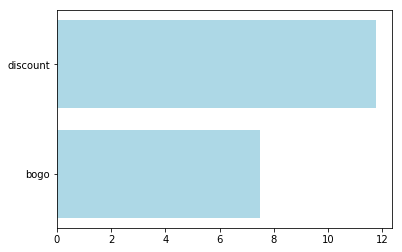

In [51]:
plt.barh(offer_diff_df.index, offer_diff_df.values, color='lightblue')

In [52]:
portfolio["reward"].describe()

count    10.000000
mean      4.200000
std       3.583915
min       0.000000
25%       2.000000
50%       4.000000
75%       5.000000
max      10.000000
Name: reward, dtype: float64

In [53]:
portfolio[portfolio["offer_type"] == "informational"]["reward"].describe()

count    2.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0
Name: reward, dtype: float64

In [54]:
portfolio[portfolio["offer_type"] == "bogo"]["reward"].describe()

count     4.000000
mean      7.500000
std       2.886751
min       5.000000
25%       5.000000
50%       7.500000
75%      10.000000
max      10.000000
Name: reward, dtype: float64

In [55]:
portfolio[portfolio["offer_type"] == "discount"]["reward"].describe()

count    4.000000
mean     3.000000
std      1.414214
min      2.000000
25%      2.000000
50%      2.500000
75%      3.500000
max      5.000000
Name: reward, dtype: float64

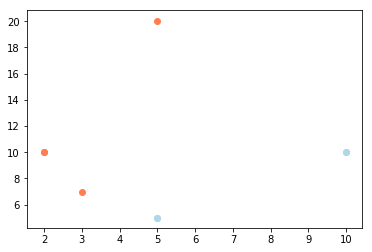

In [56]:
plt.scatter(portfolio.loc[portfolio["offer_type"] == "bogo", "reward"], portfolio.loc[portfolio["offer_type"] == "bogo", "difficulty"], c="lightblue")
plt.scatter(portfolio.loc[portfolio["offer_type"] == "discount", "reward"], portfolio.loc[portfolio["offer_type"] == "discount", "difficulty"], c="coral")

In [57]:
portfolio.loc[portfolio["offer_type"] == "bogo", "reward"]/portfolio.loc[portfolio["offer_type"] == "bogo", "difficulty"].sort_values()

0    1.0
1    1.0
3    1.0
8    1.0
dtype: float64

In [58]:
portfolio.loc[portfolio["offer_type"] == "discount", "reward"]/portfolio.loc[portfolio["offer_type"] == "discount", "difficulty"].sort_values()

4    0.250000
5    0.428571
6    0.200000
9    0.200000
dtype: float64

In [59]:
portfolio.duration.describe()

count    10.000000
mean      6.500000
std       2.321398
min       3.000000
25%       5.000000
50%       7.000000
75%       7.000000
max      10.000000
Name: duration, dtype: float64

In [60]:
portfolio.loc[portfolio["offer_type"] == "informational", "duration"].describe()

count    2.000000
mean     3.500000
std      0.707107
min      3.000000
25%      3.250000
50%      3.500000
75%      3.750000
max      4.000000
Name: duration, dtype: float64

In [61]:
portfolio.loc[portfolio["offer_type"] == "bogo", "duration"].describe()

count    4.000000
mean     6.000000
std      1.154701
min      5.000000
25%      5.000000
50%      6.000000
75%      7.000000
max      7.000000
Name: duration, dtype: float64

In [62]:
portfolio.loc[portfolio["offer_type"] == "discount", "duration"].describe()

count     4.000000
mean      8.500000
std       1.732051
min       7.000000
25%       7.000000
50%       8.500000
75%      10.000000
max      10.000000
Name: duration, dtype: float64

In [63]:
portfolio[['channel_web', 'channel_email', 'channel_mobile', 'channel_social']].sum().sort_values(ascending = False)

channel_email     10
channel_mobile     9
channel_web        8
channel_social     6
dtype: int64

the most used channels are email and mobile

In [64]:
portfolio.loc[portfolio["channel_mobile"]==0, "duration"].mean()

10.0

In [65]:
portfolio.loc[portfolio["channel_mobile"]==1, "duration"].mean()

6.1111111111111107

In [66]:
portfolio.loc[portfolio["channel_web"]==0, "duration"].mean()

5.0

In [67]:
portfolio.loc[portfolio["channel_web"]==1, "duration"].mean()

6.875

In [68]:
portfolio.loc[portfolio["channel_social"]==0, "duration"].mean()

7.0

In [69]:
portfolio.loc[portfolio["channel_social"]==1, "duration"].mean()

6.166666666666667

## Profile

In [70]:
profile.head()

,age,became_member_on,gender,customer_id,income,days_since_member
0,61.0,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,1343
1,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1190
2,61.0,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,828
3,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1257
4,61.0,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN,1170


In [71]:
profile.age.describe()

count    17000.000000
mean        55.238765
std         16.382854
min         18.000000
25%         45.000000
50%         58.000000
75%         65.000000
max        101.000000
Name: age, dtype: float64

(array([ 1169.,  1087.,  1462.,  2338.,  2894.,  4665.,  1890.,   917.,
          446.,   132.]),
 array([  18. ,   26.3,   34.6,   42.9,   51.2,   59.5,   67.8,   76.1,
          84.4,   92.7,  101. ]),
 <a list of 10 Patch objects>)

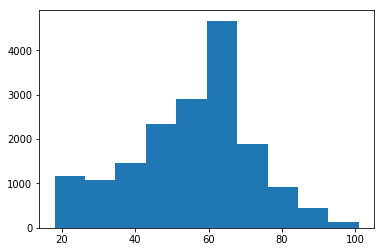

In [72]:
plt.hist(profile['age'])

In [73]:
profile.income.describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

In [74]:
profile_notnull = profile[~profile["income"].isnull()]

(array([ 1731.,  1707.,  2234.,  2210.,  2345.,  1435.,  1215.,   990.,
          498.,   460.]),
 array([  30000.,   39000.,   48000.,   57000.,   66000.,   75000.,
          84000.,   93000.,  102000.,  111000.,  120000.]),
 <a list of 10 Patch objects>)

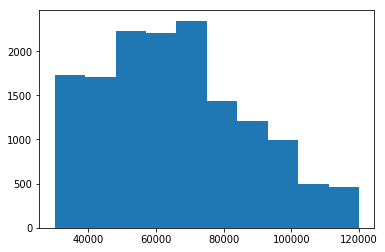

In [75]:
plt.hist(profile_notnull["income"])

In [76]:
gender_df = profile.groupby('gender')['customer_id'].count()
gender_df.head()

gender
F    6129
M    8484
O     212
Name: customer_id, dtype: int64

<Container object of 3 artists>

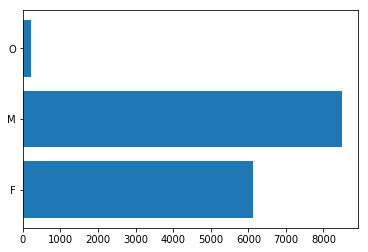

In [77]:
plt.barh(gender_df.index, gender_df.values)

In [78]:
profile['gender'] = profile['gender'].fillna('O')

In [79]:
gender_df_v2 = profile.groupby('gender')['customer_id'].count().sort_values()

<Container object of 3 artists>

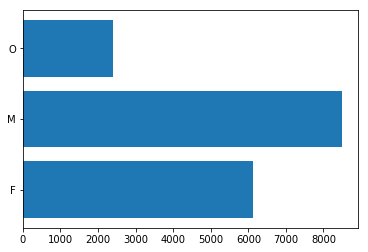

In [80]:
plt.barh(gender_df_v2.index, gender_df_v2.values)

In [81]:
profile['days_since_member'].describe()

count    17000.000000
mean      1331.449882
std        411.223904
min        814.000000
25%       1022.000000
50%       1172.000000
75%       1605.000000
max       2637.000000
Name: days_since_member, dtype: float64

In [82]:
bins = math.ceil(profile["days_since_member"].max()/365)

(array([ 4782.,  4761.,  2146.,  2260.,  1743.,   441.,   434.,   433.]),
 array([  814.   ,  1041.875,  1269.75 ,  1497.625,  1725.5  ,  1953.375,
         2181.25 ,  2409.125,  2637.   ]),
 <a list of 8 Patch objects>)

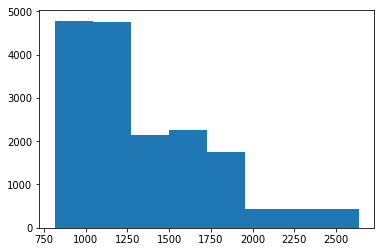

In [83]:
plt.hist(profile['days_since_member'], bins = bins)

## Transcript

In [84]:
transcript.head()

,event,customer_id,time,amount,reward,portfolio_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,0.0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0.0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,0.0,0,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,0.0,0,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,0.0,0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [85]:
transcript["event"].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [86]:
# transcript["event"] = pd.Categorical(transcript["event"], ["offer received", "offer viewed", "transaction", "offer completed"])

In [87]:
transcript["customer_id"].unique()

array(['78afa995795e4d85b5d9ceeca43f5fef',
       'a03223e636434f42ac4c3df47e8bac43',
       'e2127556f4f64592b11af22de27a7932', ...,
       '912b9f623b9e4b4eb99b6dc919f09a93',
       '3045af4e98794a04a5542d3eac939b1f',
       'da7a7c0dcfcb41a8acc7864a53cf60fb'], dtype=object)

In [88]:
transcript["event"].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [89]:
offer_by_cus = transcript.groupby("portfolio_id")["customer_id"].unique().reset_index()

In [90]:
offer_by_cus["cus_num"] = offer_by_cus["customer_id"].apply(lambda x: len(x))

In [91]:
offer_by_cus

,portfolio_id,customer_id,cus_num
0,0,"[02c083884c7d45b39cc68e1314fec56c, 9fa9ae8f578...",16578
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,"[a03223e636434f42ac4c3df47e8bac43, aa4862eba77...",6374
2,2298d6c36e964ae4a3e7e9706d1fb8c2,"[c4863c7985cf408faee930f111475da3, 9f30b375d7b...",6325
3,2906b810c7d4411798c6938adc9daaa5,"[e2127556f4f64592b11af22de27a7932, 65aba5c6172...",6285
4,3f207df678b143eea3cee63160fa8bed,"[2eeac8d8feae4a8cad5a6af0499a211d, c27e0d6ab72...",6331
5,4d5c57ea9a6940dd891ad53e9dbe8da0,"[68617ca6246f4fbc85e91a2a49552598, 102e9454054...",6330
6,5a8bc65990b245e5a138643cd4eb9837,"[be8a5d1981a2458d90b255ddc7e0d174, a5a6ef2b78a...",6320
7,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[78afa995795e4d85b5d9ceeca43f5fef, ebe7ef46ea6...",6355
8,ae264e3637204a6fb9bb56bc8210ddfd,"[4b0da7e80e5945209a1fdddfe813dbe0, 1e9420836d5...",6374
9,f19421c1d4aa40978ebb69ca19b0e20d,"[389bc3fa690240e798340f5a15918d5c, 6e014185620...",6262


In [92]:
offer_event_by_cus = transcript.groupby(["portfolio_id", "event"])["customer_id"].unique().reset_index()

In [93]:
offer_event_by_cus["cus_num"] = offer_event_by_cus["customer_id"].apply(lambda x: len(x))

In [94]:
offer_event_by_cus = offer_event_by_cus.drop("customer_id", axis = 1)

In [95]:
offer_event_by_cus.sort_values(["portfolio_id", "event"], ascending = [True, False])

,portfolio_id,event,cus_num
0,0,transaction,16578
3,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer viewed,2400
2,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer received,6374
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer completed,2978
6,2298d6c36e964ae4a3e7e9706d1fb8c2,offer viewed,6122
5,2298d6c36e964ae4a3e7e9706d1fb8c2,offer received,6325
4,2298d6c36e964ae4a3e7e9706d1fb8c2,offer completed,4421
9,2906b810c7d4411798c6938adc9daaa5,offer viewed,3608
8,2906b810c7d4411798c6938adc9daaa5,offer received,6285
7,2906b810c7d4411798c6938adc9daaa5,offer completed,3480


In [96]:
offer_event_by_cus_wo_trans = offer_event_by_cus[offer_event_by_cus["event"] != "transaction"]

In [97]:
# offer_event_by_cus_wo_trans["event"] = pd.Categorical(offer_event_by_cus_wo_trans["event"], ["offer received", "offer viewed", "offer completed"])

In [98]:
offer_event_by_cus_wo_trans.sort_values(["portfolio_id", "event"])

,portfolio_id,event,cus_num
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer completed,2978
2,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer received,6374
3,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer viewed,2400
4,2298d6c36e964ae4a3e7e9706d1fb8c2,offer completed,4421
5,2298d6c36e964ae4a3e7e9706d1fb8c2,offer received,6325
6,2298d6c36e964ae4a3e7e9706d1fb8c2,offer viewed,6122
7,2906b810c7d4411798c6938adc9daaa5,offer completed,3480
8,2906b810c7d4411798c6938adc9daaa5,offer received,6285
9,2906b810c7d4411798c6938adc9daaa5,offer viewed,3608
10,3f207df678b143eea3cee63160fa8bed,offer received,6331


In [99]:
event_x_cus_pivot = offer_event_by_cus_wo_trans.pivot(index = "portfolio_id", columns = "event", values = "cus_num")

In [100]:
new_cols = ["offer received", "offer viewed", "offer completed"]

In [101]:
event_x_cus_pivot = event_x_cus_pivot[new_cols]

In [102]:
event_x_cus_pivot.columns

Index(['offer received', 'offer viewed', 'offer completed'], dtype='object', name='event')

In [103]:
event_x_cus_pivot["offer completed"] = event_x_cus_pivot["offer completed"].fillna(0)

In [104]:
event_x_cus_pivot["offer_completed_before_viewed"] = (event_x_cus_pivot["offer completed"] - event_x_cus_pivot["offer viewed"]).values

In [105]:
event_x_cus_pivot.head()

event,offer received,offer viewed,offer completed,offer_completed_before_viewed
portfolio_id,,,,
0b1e1539f2cc45b7b9fa7c272da2e1d7,6374.0,2400.0,2978.0,578.0
2298d6c36e964ae4a3e7e9706d1fb8c2,6325.0,6122.0,4421.0,-1701.0
2906b810c7d4411798c6938adc9daaa5,6285.0,3608.0,3480.0,-128.0
3f207df678b143eea3cee63160fa8bed,6331.0,3635.0,0.0,-3635.0
4d5c57ea9a6940dd891ad53e9dbe8da0,6330.0,6132.0,2885.0,-3247.0


In [106]:
event_x_cus_pivot.loc[event_x_cus_pivot["offer_completed_before_viewed"] < 0, "offer_completed_before_viewed"] = 0

In [107]:
event_x_cus_pivot

event,offer received,offer viewed,offer completed,offer_completed_before_viewed
portfolio_id,,,,
0b1e1539f2cc45b7b9fa7c272da2e1d7,6374.0,2400.0,2978.0,578.0
2298d6c36e964ae4a3e7e9706d1fb8c2,6325.0,6122.0,4421.0,0.0
2906b810c7d4411798c6938adc9daaa5,6285.0,3608.0,3480.0,0.0
3f207df678b143eea3cee63160fa8bed,6331.0,3635.0,0.0,0.0
4d5c57ea9a6940dd891ad53e9dbe8da0,6330.0,6132.0,2885.0,0.0
5a8bc65990b245e5a138643cd4eb9837,6320.0,5674.0,0.0,0.0
9b98b8c7a33c4b65b9aebfe6a799e6d9,6355.0,3658.0,3784.0,126.0
ae264e3637204a6fb9bb56bc8210ddfd,6374.0,5696.0,3177.0,0.0
f19421c1d4aa40978ebb69ca19b0e20d,6262.0,6060.0,3741.0,0.0


In [108]:
event_x_cus_pivot["ctr_received_2_viewed"] = event_x_cus_pivot["offer viewed"]/event_x_cus_pivot["offer received"]

In [109]:
event_x_cus_pivot["ctr_viewed_2_completed"] = event_x_cus_pivot["offer completed"]/event_x_cus_pivot["offer viewed"]

In [110]:
event_x_cus_pivot["ctr_received_2_completed"] = event_x_cus_pivot["offer completed"]/event_x_cus_pivot["offer received"]

In [111]:
# event_x_cus_pivot = event_x_cus_pivot[["offer received", "offer viewed", "offer completed", "offer_completed_before_viewed", "ctr_received_2_viewed", "ctr_viewed_2_completed", "ctr_received_2_completed"]]

In [112]:
event_x_cus_pivot = event_x_cus_pivot.sort_values(by=["ctr_received_2_completed", "ctr_viewed_2_completed"], ascending = [False, False])

In [113]:
event_x_cus_pivot.head(3)

event,offer received,offer viewed,offer completed,offer_completed_before_viewed,ctr_received_2_viewed,ctr_viewed_2_completed,ctr_received_2_completed
portfolio_id,,,,,,,
fafdcd668e3743c1bb461111dcafc2a4,6332.0,6150.0,4530.0,0.0,0.971257,0.736585,0.715414
2298d6c36e964ae4a3e7e9706d1fb8c2,6325.0,6122.0,4421.0,0.0,0.967905,0.722150,0.698972
f19421c1d4aa40978ebb69ca19b0e20d,6262.0,6060.0,3741.0,0.0,0.967742,0.617327,0.597413


In [114]:
top_ctr_rate_offers = event_x_cus_pivot.index[:3].values

In [115]:
portfolio[portfolio["portfolio_id"].isin(list(top_ctr_rate_offers))]

,difficulty,duration,portfolio_id,offer_type,reward,channel_web,channel_email,channel_mobile,channel_social
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1


The top 3 offers have great conversion rates overall. And 2 of them are discount offers. **Discount offers more popular?** 

In [116]:
con1 = (transcript["portfolio_id"].isin(["0b1e1539f2cc45b7b9fa7c272da2e1d7", "9b98b8c7a33c4b65b9aebfe6a799e6d9"]))
con2 = (transcript["event"].isin(["offer viewed", "offer completed"]))

In [117]:
completed_before_viewed_df1 = transcript.loc[con1 & con2]

In [118]:
completed_before_viewed_df1["offer_completed"] = (completed_before_viewed_df1["event"] == 'offer completed').astype(int)
completed_before_viewed_df1["offer_viewed"] = (completed_before_viewed_df1["event"] == 'offer viewed').astype(int)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [119]:
completed_before_viewed_df1_agg = completed_before_viewed_df1.groupby(["portfolio_id", "customer_id"]).agg({"offer_viewed":sum, "offer_completed":sum}).reset_index()

In [120]:
completed_before_viewed_df1_agg.head()

,portfolio_id,customer_id,offer_viewed,offer_completed
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0011e0d4e6b944f998e987f904e8c1e5,1,1
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,003d66b6608740288d6cc97a6903f4f0,0,1
2,0b1e1539f2cc45b7b9fa7c272da2e1d7,0056df74b63b4298809f0b375a304cf4,0,1
3,0b1e1539f2cc45b7b9fa7c272da2e1d7,0063def0f9c14bc4805322a488839b32,1,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,00715b6e55c3431cb56ff7307eb19675,1,2


In [121]:
con3 = (completed_before_viewed_df1_agg["offer_completed"]>completed_before_viewed_df1_agg["offer_viewed"])
con4 = ["portfolio_id", "customer_id"]

In [122]:
len(completed_before_viewed_df1_agg.loc[con3, con4].groupby("portfolio_id")["customer_id"].unique().values[0])

1667

In [123]:
len(completed_before_viewed_df1_agg.loc[con3, con4].groupby("portfolio_id")["customer_id"].unique().values[1])

1468

The differences above don't match with the ones I got from the pivot table. Why?

Some customers got the offers more than once. Did they take the offer everytime?

In [124]:
cus_offer_matrix = transcript.groupby(["customer_id", "portfolio_id", "event"])["event"].count().unstack().reset_index()

In [125]:
cus_offer_matrix  = cus_offer_matrix.fillna(0)

In [126]:
cus_offer_matrix.head()

event,customer_id,portfolio_id,offer completed,offer received,offer viewed,transaction
0,0009655768c64bdeb2e877511632db8f,0,0.0,0.0,0.0,8.0
1,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1.0,1.0,0.0,0.0
2,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,1.0,1.0,0.0
3,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,1.0,1.0,0.0
4,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0,1.0,1.0,0.0


In [127]:
cus_offer_matrix.loc[cus_offer_matrix["offer received"] > 1, \
                     ["customer_id", "portfolio_id"]].drop_duplicates().count()[0]

11718

In [128]:
cus_offer_matrix.loc[(cus_offer_matrix["offer received"] > 1) \
                 & (cus_offer_matrix["offer completed"] < cus_offer_matrix["offer received"]), \
                     ["customer_id", "portfolio_id"]].drop_duplicates().count()[0]

7686

In [129]:
print("Within the customers who received an offer multiple times,{}% of \
them complete all the offers".format(str(round((7686/11718)*100, 2))))

Within the customers who received an offer multiple times,65.59% of them complete all the offers


In [130]:
cus_complete_all_offers = cus_offer_matrix.loc[(cus_offer_matrix["offer received"] > 1) \
                 & (cus_offer_matrix["offer completed"] == cus_offer_matrix["offer received"]), \
                     ["customer_id", "portfolio_id"]].drop_duplicates()["customer_id"].unique()

In [131]:
cus_complete_all_offers = list(cus_complete_all_offers)

In [132]:
cus_complete_all_offers[:10]

['0020c2b971eb4e9188eac86d93036a77',
 '003d66b6608740288d6cc97a6903f4f0',
 '004c5799adbf42868b9cff0396190900',
 '00715b6e55c3431cb56ff7307eb19675',
 '0082fd87c18f45f2be70dbcbb0fb8aad',
 '0091d2b6a5ea4defaa8393e4e816db60',
 '00ae03011f9f49b8a4b3e6d416678b0b',
 '00b18b535d6d4f779dea4dc9ac451478',
 '00bc42a62f884b41a13cc595856cf7c3',
 '00c91f31f5f74e769fa7a359b63e1a9f']

In [133]:
transcript.loc[transcript["customer_id"].isin(cus_complete_all_offers), "amount"].mean()

8.0276367501126344

In [134]:
transcript.loc[~transcript["customer_id"].isin(cus_complete_all_offers), "amount"].mean()

4.9122641166335557

The customers who finished all the offers spend 2 times as the customers didn't finish all the offers. But the 20% top customers are not the same as the customers who finish all the offers.

In [135]:
transcript.loc[transcript["customer_id"].isin(cus_complete_all_offers) \
               & transcript["amount"] > 0
               , "amount"].values

array([ 28.08,  13.57,  27.89, ...,  18.35,  25.14,   3.61])

In [136]:
diff_cus_type_trans = pd.DataFrame()

In [137]:
diff_cus_type_trans = transcript.loc[(transcript["amount"]> 0) & (transcript["amount"] <= 10), ["customer_id", "amount"]]

In [138]:
diff_cus_type_trans["freq_cus_yn"] = transcript["customer_id"].isin(cus_complete_all_offers)

In [139]:
# plt.axvline(x=lower_bound, color = 'red'); # where our sample mean falls on null dist
# plt.axvline(x=upper_bound, color = 'red');

In [140]:
# fre_customer_trans = transcript.loc[transcript["customer_id"].isin(cus_complete_all_offers) \
#                & transcript["amount"] > 0
#                , "amount"].values
# non_fre_customer_trans = transcript.loc[~transcript["customer_id"].isin(cus_complete_all_offers) \
#                & transcript["amount"] > 0
#                , "amount"].values

In [141]:
transcript[transcript["amount"]>100].count()

event           478
customer_id     478
time            478
amount          478
reward          478
portfolio_id    478
dtype: int64

In [142]:
transcript.count()

event           306534
customer_id     306534
time            306534
amount          306534
reward          306534
portfolio_id    306534
dtype: int64

In [143]:
transcript[transcript["amount"]>10].count()/transcript.count()

event           0.212929
customer_id     0.212929
time            0.212929
amount          0.212929
reward          0.212929
portfolio_id    0.212929
dtype: float64

In [144]:
transcript.loc[transcript["amount"]>10, "amount"].sum()/transcript["amount"].sum()

0.84736740583300596

Top 20% customer contributed 80% transaction amount.

In [145]:
transcript[(transcript["amount"]>10) & (transcript["customer_id"].isin(cus_complete_all_offers))].count()

event           26956
customer_id     26956
time            26956
amount          26956
reward          26956
portfolio_id    26956
dtype: int64

In [146]:
transcript[(transcript["amount"]>10) & (transcript["customer_id"].isin(cus_complete_all_offers))].count()/ \
transcript[transcript["amount"]>10].count()

event           0.412992
customer_id     0.412992
time            0.412992
amount          0.412992
reward          0.412992
portfolio_id    0.412992
dtype: float64

In [147]:
transcript.loc[(transcript["amount"]>10) & (transcript["customer_id"].isin(cus_complete_all_offers)), "amount"].sum()/ \
transcript.loc[transcript["amount"]>10, "amount"].sum()

0.4193077752083732

The customers who complete all the offers account for 41% of the top 20% customers and 41% of the 80% revenue. Does this mean about 60% the most valued customers are not very sensitive to the offer? How to approve?

In [148]:
diff_cus_type_trans.loc[diff_cus_type_trans["amount"] < 10, "amount"].describe()

count    73650.000000
mean         3.674974
std          2.724833
min          0.050000
25%          1.400000
50%          2.980000
75%          5.580000
max          9.990000
Name: amount, dtype: float64

In [149]:
freq_cus = diff_cus_type_trans.loc[diff_cus_type_trans["freq_cus_yn"] == True, "amount"].mean()
non_freq_cus = diff_cus_type_trans.loc[diff_cus_type_trans["freq_cus_yn"] == False, "amount"].mean()

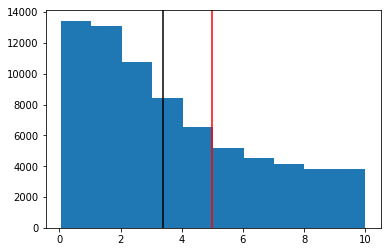

In [150]:
plt.hist(diff_cus_type_trans["amount"])
plt.axvline(x=freq_cus, color = 'red'); # where our sample mean falls on null dist
plt.axvline(x=non_freq_cus, color = 'black');

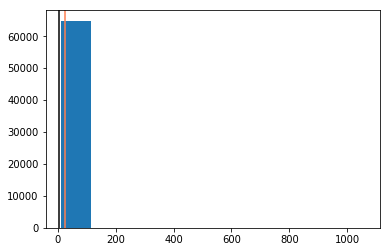

In [151]:
high_m_cus = transcript.loc[transcript["amount"]>10, "amount"]
high_m_cus_mean = high_m_cus.mean()
plt.hist(high_m_cus)
plt.axvline(x=freq_cus, color = 'black');
plt.axvline(x=high_m_cus_mean, color='coral')
# plt.xscale("log")
# plt.yscale("log")

In [152]:
cus_rm_df = transcript.groupby("customer_id").agg({"time":max, "amount":sum}).reset_index()
cus_f_df = transcript[transcript["amount"] > 0].groupby("customer_id")["event"].count().reset_index()

In [153]:
cus_rm_df.loc[cus_rm_df["amount"] == 0, "customer_id"].count()

422

In [154]:
len(cus_rm_df["customer_id"].unique()) - len(cus_f_df["customer_id"].unique())

422

In [155]:
cus_wo_purchase = cus_rm_df.loc[cus_rm_df["amount"] == 0, "customer_id"]

In [156]:
cus_rfm_df = cus_rm_df.merge(cus_f_df, on= "customer_id", how="left")

In [157]:
cus_rfm_df.columns = ["customer_id", "recency", "monetary", "frequency"]

In [158]:
cus_rfm_df.isnull().sum()

customer_id      0
recency          0
monetary         0
frequency      422
dtype: int64

In [159]:
cus_rfm_df.head()

,customer_id,recency,monetary,frequency
0,0009655768c64bdeb2e877511632db8f,696,127.60,8.0
1,00116118485d4dfda04fdbaba9a87b5c,630,4.09,3.0
2,0011e0d4e6b944f998e987f904e8c1e5,654,79.46,5.0
3,0020c2b971eb4e9188eac86d93036a77,708,196.86,8.0
4,0020ccbbb6d84e358d3414a3ff76cffd,672,154.05,12.0


In [160]:
cus_rfm_df["frequency"] = cus_rfm_df["frequency"].fillna(0)

In [161]:
cus_rfm_df.isnull().sum()

customer_id    0
recency        0
monetary       0
frequency      0
dtype: int64

In [162]:
cus_rfm_df.head()

,customer_id,recency,monetary,frequency
0,0009655768c64bdeb2e877511632db8f,696,127.60,8.0
1,00116118485d4dfda04fdbaba9a87b5c,630,4.09,3.0
2,0011e0d4e6b944f998e987f904e8c1e5,654,79.46,5.0
3,0020c2b971eb4e9188eac86d93036a77,708,196.86,8.0
4,0020ccbbb6d84e358d3414a3ff76cffd,672,154.05,12.0


In [163]:
quantiles = cus_rfm_df.quantile(q=[0.8])
print(quantiles)

     recency  monetary  frequency
0.8    696.0   168.652       12.0


In [164]:
cus_rfm_df["R"] = np.where(cus_rfm_df["recency"]<=int(quantiles["recency"].values), 2, 1)
cus_rfm_df["F"] = np.where(cus_rfm_df["frequency"]<=int(quantiles["frequency"].values), 2, 1)
cus_rfm_df["M"] = np.where(cus_rfm_df["monetary"]<=int(quantiles["monetary"].values), 2, 1)

In [165]:
cus_rfm_df.head()

,customer_id,recency,monetary,frequency,R,F,M
0,0009655768c64bdeb2e877511632db8f,696,127.60,8.0,2,2,2
1,00116118485d4dfda04fdbaba9a87b5c,630,4.09,3.0,2,2,2
2,0011e0d4e6b944f998e987f904e8c1e5,654,79.46,5.0,2,2,2
3,0020c2b971eb4e9188eac86d93036a77,708,196.86,8.0,1,2,1
4,0020ccbbb6d84e358d3414a3ff76cffd,672,154.05,12.0,2,2,2


In [166]:
cus_rfm_df["RFMScore"] = cus_rfm_df["M"].map(str)  + cus_rfm_df["R"].map(str) + cus_rfm_df["F"].map(str)
# cus_rfm_df["RFMScore"] = cus_rfm_df["M"].map(str)  + cus_rfm_df["R"].map(str)

In [167]:
cus_rfm_df.sort_values("RFMScore").head()

,customer_id,recency,monetary,frequency,R,F,M,RFMScore
9291,8b9658d02943407d8e014a9bc971a3d5,708,297.33,18.0,1,1,1,111
4712,46a8553f78b0444c859579017100c0ae,702,289.20,17.0,1,1,1,111
10381,9b4b02ab6a744385ae6007e4c95099cc,708,201.12,20.0,1,1,1,111
4725,46c83dc0af064389b29ccf97d9c7ed57,702,362.07,17.0,1,1,1,111
4774,478f3d690f8640e8b017e13a794936a0,714,239.80,22.0,1,1,1,111


Generate FRMScore and use it to classify customer. Use is as new feature and feed into the model. Need to compare with the results of Clustering

In [168]:
FRMScore_df = cus_rfm_df[["customer_id", "RFMScore"]]

In [169]:
transcript["time"].describe()

count    306534.000000
mean        366.382940
std         200.326314
min           0.000000
25%         186.000000
50%         408.000000
75%         528.000000
max         714.000000
Name: time, dtype: float64

In [170]:
initial_date = pd.Timestamp("05/01/2020")

In [171]:
transcript["datetime"] = initial_date + pd.to_timedelta(transcript["time"], unit='h')

In [172]:
portfolio[["portfolio_id", "duration"]].head()

,portfolio_id,duration
0,ae264e3637204a6fb9bb56bc8210ddfd,7
1,4d5c57ea9a6940dd891ad53e9dbe8da0,5
2,3f207df678b143eea3cee63160fa8bed,4
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,7
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,10


In [173]:
# offer_received_df = transcript[transcript["event"]=="offer received"].merge(portfolio[["portfolio_id", "duration"]], how = "left", on ="portfolio_id")

In [174]:
trans_x_pf_df = transcript.merge(portfolio[["portfolio_id", "duration"]], how = "left", on ="portfolio_id")

In [175]:
trans_x_pf_df["offer_end_date"] = trans_x_pf_df.loc[trans_x_pf_df["event"] == "offer received", "datetime"] + \
pd.to_timedelta(trans_x_pf_df["duration"], unit='d')

In [176]:
trans_x_pf_df = trans_x_pf_df.drop(columns = ["duration", "time"])

In [177]:
trans_x_pf_df.sort_values(by=["customer_id", "portfolio_id", "datetime"]).head()

,event,customer_id,amount,reward,portfolio_id,datetime,offer_end_date
89291,transaction,0009655768c64bdeb2e877511632db8f,22.16,0,0,2020-05-10 12:00:00,NaT
168412,transaction,0009655768c64bdeb2e877511632db8f,8.57,0,0,2020-05-18 06:00:00,NaT
228422,transaction,0009655768c64bdeb2e877511632db8f,14.11,0,0,2020-05-23 00:00:00,NaT
237784,transaction,0009655768c64bdeb2e877511632db8f,13.56,0,0,2020-05-24 00:00:00,NaT
258883,transaction,0009655768c64bdeb2e877511632db8f,10.27,0,0,2020-05-25 00:00:00,NaT


In [178]:
trans_offer_df = trans_x_pf_df.loc[trans_x_pf_df["event"] != "transaction", ["customer_id", "portfolio_id", "event", "datetime", "offer_end_date"]]

In [179]:
trans_trans_df = trans_x_pf_df.loc[trans_x_pf_df["event"] == "transaction", ["customer_id", "portfolio_id", "event", "datetime"]]

In [180]:
# trans_offer_rank = trans_offer_df.groupby(["customer_id", "portfolio_id", "event"])["datetime"].rank()

In [181]:
trans_offer_df = trans_offer_df.sort_values(by=["customer_id", "portfolio_id", "datetime"]).fillna(method = "ffill")

In [182]:
trans_offer_df.head()

,customer_id,portfolio_id,event,datetime,offer_end_date
247879,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,offer received,2020-05-25 00:00:00,2020-06-01
258884,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,offer completed,2020-05-25 00:00:00,2020-06-01
113605,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,offer received,2020-05-15 00:00:00,2020-05-19
139992,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,offer viewed,2020-05-16 12:00:00,2020-05-19
55972,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,offer received,2020-05-08 00:00:00,2020-05-11


In [183]:
# trans_offer_rank_df = pd.concat([trans_offer_df, trans_offer_rank], axis = 1)
# trans_offer_rank_df.columns = ["customer_id", "portfolio_id", "event", "datetime", "offer_end_date", "num"]

In [184]:
# trans_offer_rank_df = trans_offer_rank_df[["customer_id", "portfolio_id", "num", "event", "datetime", "offer_end_date"]]

In [185]:
trans_offer_rank_df = trans_offer_df[["customer_id", "portfolio_id", "event", "datetime", "offer_end_date"]]

In [186]:
# trans_offer_df[(trans_offer_df["customer_id"] == "ffff82501cea40309d5fdd7edcca4a07") & \
#                (trans_offer_df["portfolio_id"] == "0b1e1539f2cc45b7b9fa7c272da2e1d7")]

In [187]:
trans_offer_rank_matrix = trans_offer_rank_df.groupby(["customer_id", "portfolio_id", "offer_end_date", "event"]).agg({"datetime":min}).unstack()

In [188]:
trans_offer_rank_matrix = trans_offer_rank_matrix.reset_index()

In [189]:
trans_offer_tm_df = pd.DataFrame()

In [190]:
trans_offer_tm_df["customer_id"] = trans_offer_rank_matrix["customer_id"]
trans_offer_tm_df["offer_start_date"] = trans_offer_rank_matrix["datetime"]["offer received"]
trans_offer_tm_df["offer_end_date"] = trans_offer_rank_matrix["offer_end_date"]
trans_offer_tm_df["offer_viewed_date"] = trans_offer_rank_matrix["datetime"]["offer viewed"]
trans_offer_tm_df["offer_completed_date"] = trans_offer_rank_matrix["datetime"]["offer completed"]

In [191]:
trans_offer_tm_df.head()

,customer_id,offer_start_date,offer_end_date,offer_viewed_date,offer_completed_date
0,0009655768c64bdeb2e877511632db8f,2020-05-25,2020-06-01,NaT,2020-05-25 00:00:00
1,0009655768c64bdeb2e877511632db8f,2020-05-15,2020-05-19,2020-05-16 12:00:00,NaT
2,0009655768c64bdeb2e877511632db8f,2020-05-08,2020-05-11,2020-05-09 00:00:00,NaT
3,0009655768c64bdeb2e877511632db8f,2020-05-18,2020-05-23,2020-05-20 00:00:00,2020-05-18 06:00:00
4,0009655768c64bdeb2e877511632db8f,2020-05-22,2020-06-01,2020-05-23 12:00:00,2020-05-23 00:00:00


In [192]:
trans_trans_df["purchased_yn"] = True

In [193]:
trans_trans_matrix = trans_trans_df.groupby(["datetime", "customer_id"]).agg({"purchased_yn":min}).unstack()

In [194]:
trans_offer_tm_nc_df = trans_offer_tm_df.loc[trans_offer_tm_df["offer_completed_date"].isnull(), \
                                             ["customer_id", "offer_start_date", "offer_end_date"]]

In [195]:
trans_trans_matrix.index

DatetimeIndex(['2020-05-01 00:00:00', '2020-05-01 06:00:00',
               '2020-05-01 12:00:00', '2020-05-01 18:00:00',
               '2020-05-02 00:00:00', '2020-05-02 06:00:00',
               '2020-05-02 12:00:00', '2020-05-02 18:00:00',
               '2020-05-03 00:00:00', '2020-05-03 06:00:00',
               ...
               '2020-05-28 12:00:00', '2020-05-28 18:00:00',
               '2020-05-29 00:00:00', '2020-05-29 06:00:00',
               '2020-05-29 12:00:00', '2020-05-29 18:00:00',
               '2020-05-30 00:00:00', '2020-05-30 06:00:00',
               '2020-05-30 12:00:00', '2020-05-30 18:00:00'],
              dtype='datetime64[ns]', name='datetime', length=120, freq=None)

In [196]:
trans_offer_tm_nc_df.head()

,customer_id,offer_start_date,offer_end_date
1,0009655768c64bdeb2e877511632db8f,2020-05-15,2020-05-19
2,0009655768c64bdeb2e877511632db8f,2020-05-08,2020-05-11
5,00116118485d4dfda04fdbaba9a87b5c,2020-05-08,2020-05-13
6,00116118485d4dfda04fdbaba9a87b5c,2020-05-25,2020-05-30
9,0011e0d4e6b944f998e987f904e8c1e5,2020-05-01,2020-05-05


In [197]:
trans_offer_tm_nc_df.iloc[0, 1]

Timestamp('2020-05-15 00:00:00')

In [198]:
trans_offer_tm_nc_df["purchased_yn"] = 0

In [199]:
trans_offer_tm_nc_df.head()

,customer_id,offer_start_date,offer_end_date,purchased_yn
1,0009655768c64bdeb2e877511632db8f,2020-05-15,2020-05-19,0
2,0009655768c64bdeb2e877511632db8f,2020-05-08,2020-05-11,0
5,00116118485d4dfda04fdbaba9a87b5c,2020-05-08,2020-05-13,0
6,00116118485d4dfda04fdbaba9a87b5c,2020-05-25,2020-05-30,0
9,0011e0d4e6b944f998e987f904e8c1e5,2020-05-01,2020-05-05,0


In [200]:
inds = trans_offer_tm_nc_df.index.tolist()

In [201]:
len(inds)

43176

In [202]:
amt_x_time = transcript.groupby("datetime")["amount"].sum().reset_index()

In [203]:
amt_x_time.head()

,datetime,amount
0,2020-05-01 00:00:00,7305.57
1,2020-05-01 06:00:00,9923.66
2,2020-05-01 12:00:00,12859.51
3,2020-05-01 18:00:00,13961.60
4,2020-05-02 00:00:00,11559.57


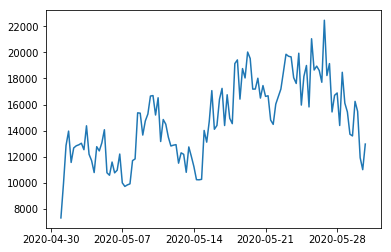

In [204]:
plt.plot(amt_x_time["datetime"], amt_x_time["amount"])

In [205]:
cusnum_x_time = transcript.groupby("datetime")["customer_id"].unique().reset_index()

In [206]:
cusnum_x_time["cus_num"] = cusnum_x_time["customer_id"].apply(lambda x: len(x))

In [207]:
cusnum_x_time.head()

,datetime,customer_id,cus_num
0,2020-05-01 00:00:00,"[78afa995795e4d85b5d9ceeca43f5fef, a03223e6364...",12761
1,2020-05-01 06:00:00,"[78afa995795e4d85b5d9ceeca43f5fef, a03223e6364...",2068
2,2020-05-01 12:00:00,"[8ec6ce2a7e7949b1bf142def7d0e0586, f082d80f0aa...",1811
3,2020-05-01 18:00:00,"[0610b486422d4921ae7d2bf64640c50b, e2127556f4f...",1666
4,2020-05-02 00:00:00,"[c4863c7985cf408faee930f111475da3, d1ede868e29...",1586


In [208]:
cusnum_x_time["datetime"].describe()

count                     120
unique                    120
top       2020-05-29 00:00:00
freq                        1
first     2020-05-01 00:00:00
last      2020-05-30 18:00:00
Name: datetime, dtype: object

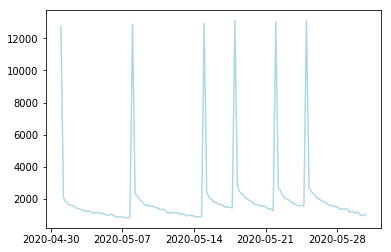

In [209]:
plt.plot(cusnum_x_time["datetime"], cusnum_x_time["cus_num"], c = 'lightblue')
# plt.yscale('log')

In [210]:
p_x_time = transcript[transcript["portfolio_id"] != 0].groupby("datetime")["portfolio_id"].unique().reset_index()

In [211]:
p_x_time["port_num"] = p_x_time["portfolio_id"].apply(lambda x: len(x))

In [212]:
p_x_time["portfolio_id"][0]

array(['9b98b8c7a33c4b65b9aebfe6a799e6d9',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '2906b810c7d4411798c6938adc9daaa5',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       '3f207df678b143eea3cee63160fa8bed',
       'ae264e3637204a6fb9bb56bc8210ddfd',
       '5a8bc65990b245e5a138643cd4eb9837'], dtype=object)

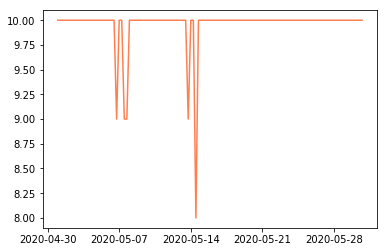

In [213]:
plt.plot(p_x_time["datetime"], p_x_time["port_num"], c = 'coral')

In [214]:
transcript.groupby("portfolio_id").agg({"datetime": [min, max]})

datetime                    
                                        min                 max
portfolio_id                                                   
0                                2020-05-01 2020-05-30 18:00:00
0b1e1539f2cc45b7b9fa7c272da2e1d7 2020-05-01 2020-05-30 18:00:00
2298d6c36e964ae4a3e7e9706d1fb8c2 2020-05-01 2020-05-30 18:00:00
2906b810c7d4411798c6938adc9daaa5 2020-05-01 2020-05-30 18:00:00
3f207df678b143eea3cee63160fa8bed 2020-05-01 2020-05-30 18:00:00
4d5c57ea9a6940dd891ad53e9dbe8da0 2020-05-01 2020-05-30 18:00:00
5a8bc65990b245e5a138643cd4eb9837 2020-05-01 2020-05-30 18:00:00
9b98b8c7a33c4b65b9aebfe6a799e6d9 2020-05-01 2020-05-30 18:00:00
ae264e3637204a6fb9bb56bc8210ddfd 2020-05-01 2020-05-30 18:00:00
f19421c1d4aa40978ebb69ca19b0e20d 2020-05-01 2020-05-30 18:00:00
fafdcd668e3743c1bb461111dcafc2a4 2020-05-01 2020-05-30 18:00:00

In [215]:
transcript.groupby("customer_id")["amount"].sum().describe()

count    17000.000000
mean       104.438351
std        125.922619
min          0.000000
25%         21.820000
50%         69.405000
75%        148.782500
max       1608.690000
Name: amount, dtype: float64

(array([  33579.,       0.,       0.,   76277.,       0.,       0.,
          57725.,       0.,       0.,  138953.]),
 array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
 <a list of 10 Patch objects>)

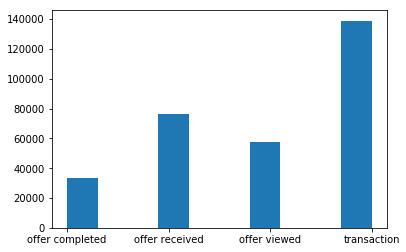

In [216]:
plt.hist(transcript["event"])

In [217]:
transcript.groupby("event")["event"].count()

event
offer completed     33579
offer received      76277
offer viewed        57725
transaction        138953
Name: event, dtype: int64

In [218]:
transcript["amount"].describe()

count    306534.000000
mean          5.792023
std          21.337137
min           0.000000
25%           0.000000
50%           0.000000
75%           7.100000
max        1062.280000
Name: amount, dtype: float64

(array([  3.06078000e+05,   9.20000000e+01,   6.10000000e+01,
          7.20000000e+01,   6.70000000e+01,   5.50000000e+01,
          4.70000000e+01,   3.60000000e+01,   1.70000000e+01,
          9.00000000e+00]),
 array([    0.   ,   106.228,   212.456,   318.684,   424.912,   531.14 ,
          637.368,   743.596,   849.824,   956.052,  1062.28 ]),
 <a list of 10 Patch objects>)

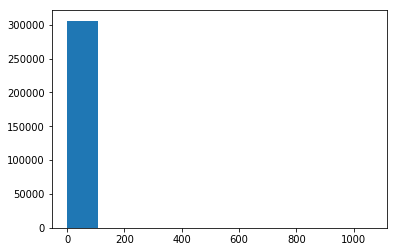

In [219]:
plt.hist(transcript["amount"])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f24d19b7e48>,
 'caps': [<matplotlib.lines.Line2D at 0x7f24d19bc940>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f24d19b7cc0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f24d19c0470>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f24d19c09b0>],
 'means': []}

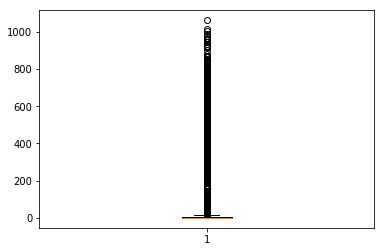

In [220]:
plt.boxplot(transcript["amount"])

(-53.114000000000004, 200)

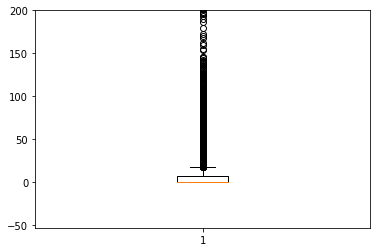

In [221]:
plt.boxplot(transcript['amount'])
plt.ylim(top=200)

In [222]:
transcript["reward"].describe()

count    306534.000000
mean          0.537219
std           1.805208
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          10.000000
Name: reward, dtype: float64

In [223]:
reward_x_time = transcript.groupby("datetime")["reward"].sum().reset_index()

In [224]:
reward_x_time.head()

,datetime,reward
0,2020-05-01 00:00:00,1092
1,2020-05-01 06:00:00,1394
2,2020-05-01 12:00:00,1438
3,2020-05-01 18:00:00,1189
4,2020-05-02 00:00:00,1325


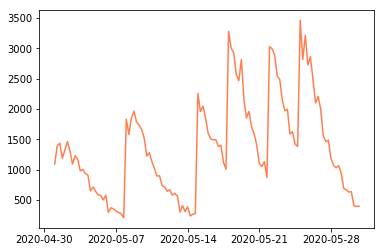

In [225]:
plt.plot(reward_x_time["datetime"], reward_x_time["reward"], color = "coral")

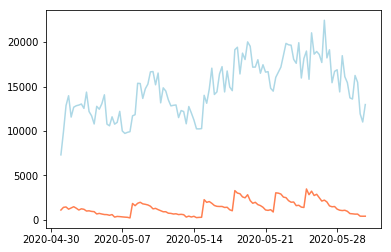

In [226]:
plt.plot(amt_x_time["datetime"], amt_x_time["amount"], color = 'lightblue')
plt.plot(reward_x_time["datetime"], reward_x_time["reward"], color = "coral")
# plt.yscale('log')

In [227]:
np.corrcoef(transcript["reward"], transcript["amount"])

array([[ 1.        , -0.08078297],
       [-0.08078297,  1.        ]])

In [228]:
sum(transcript.groupby("customer_id")['amount'].sum().sort_values(ascending = False) > 0)

16578

In [229]:
len(transcript["customer_id"].unique())

17000

In [230]:
16578/17000

0.9751764705882353

## Define offer related transactions

In [231]:
transcript["event"].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [232]:
transcript.columns

Index(['event', 'customer_id', 'time', 'amount', 'reward', 'portfolio_id',
       'datetime'],
      dtype='object')

In [233]:
event = ["offer received", "transaction", "offer completed"]
columns = ["customer_id", "portfolio_id", "event", "time", "amount"]

In [234]:
transcript_new = transcript.loc[transcript["event"].isin(event), columns]

In [235]:
portfolio.head()

,difficulty,duration,portfolio_id,offer_type,reward,channel_web,channel_email,channel_mobile,channel_social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0


In [236]:
transcript_new = transcript_new.merge(portfolio, on="portfolio_id", how="left")[["customer_id", "portfolio_id", "event", "time",\
                                                               "amount", "duration", "offer_type"]]

In [237]:
transcript_new["duration"] = transcript_new["duration"] * 24

In [238]:
transcript_new.head()

,customer_id,portfolio_id,event,time,amount,duration,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer received,0,0.0,168.0,bogo
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer received,0,0.0,240.0,discount
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,offer received,0,0.0,168.0,discount
3,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,offer received,0,0.0,240.0,discount
4,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,offer received,0,0.0,120.0,bogo


In [239]:
eva_df = transcript_new[transcript_new["event"] == "offer received"].groupby(["customer_id", "portfolio_id", "offer_type"])\
.agg({"time":pd.Series.nunique}).reset_index()

In [240]:
eva_df.head()

,customer_id,portfolio_id,offer_type,time
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,discount,1
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,informational,1
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,informational,1
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,bogo,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,discount,1


In [241]:
eva_df.loc[eva_df["time"]>1, "offer_type"].unique()

array(['bogo', 'discount', 'informational'], dtype=object)

# Split the data by offer type. Set assumptions below:
1. bogo offers count the transactions when the offer completed (The same time as offer completed)
2. discount offers need to complete sub-tasks before complete the offer. The transactions between offer received and offer completed/offer ends
3. info offers count the transactions between offer received and offer ends

In [242]:
transcript_new["offer_type"].unique()

array(['bogo', 'discount', 'informational', nan], dtype=object)

In [243]:
transcript_bogo_df = transcript_new[transcript_new["offer_type"] == "bogo"]
transcript_disc_df = transcript_new[transcript_new["offer_type"] == "discount"]
transcript_info_df = transcript_new[transcript_new["offer_type"] == "informational"]

In [244]:
transcript_info_received_df = transcript_info_df[transcript_info_df["event"] == "offer received"]
transcript_disc_received_df = transcript_disc_df[transcript_disc_df["event"] == "offer received"]
transcript_bogo_received_df = transcript_bogo_df[transcript_bogo_df["event"] == "offer received"]

In [245]:
transcript_info_received_df["offer_end_time"] = transcript_info_received_df["time"] + transcript_info_received_df["duration"]
transcript_disc_received_df["offer_end_time"] = transcript_disc_received_df["time"] + transcript_disc_received_df["duration"]
transcript_bogo_received_df["offer_end_time"] = transcript_bogo_received_df["time"] + transcript_bogo_received_df["duration"]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [246]:
transcript_info_received_df = transcript_info_received_df.rename(columns = {"time":"offer_received_time"})
transcript_disc_received_df = transcript_disc_received_df.rename(columns = {"time":"offer_received_time"})
transcript_bogo_received_df = transcript_bogo_received_df.rename(columns = {"time":"offer_received_time"})

In [247]:
transcript_disc_completed_df = transcript_disc_df[transcript_disc_df["event"] == "offer completed"]
transcript_bogo_completed_df = transcript_bogo_df[transcript_bogo_df["event"] == "offer completed"]

In [248]:
transcript_bogo_completed_df = transcript_bogo_completed_df.rename(columns = {"time":"offer_completed_time"})
transcript_disc_completed_df = transcript_disc_completed_df.rename(columns = {"time":"offer_completed_time"})

In [249]:
transcript_bogo_final_df_temp = transcript_bogo_received_df.merge(transcript_bogo_completed_df, how = "left", on = ["customer_id", "portfolio_id"])

In [250]:
transcript_disc_final_df_temp = transcript_disc_received_df.merge(transcript_disc_completed_df, how = "left", on = ["customer_id", "portfolio_id"])

In [251]:
transcript_bogo_final_df_temp = transcript_bogo_final_df_temp[((transcript_bogo_final_df_temp["offer_completed_time"] >= \
                                 transcript_bogo_final_df_temp["offer_received_time"]) &
                                 (transcript_bogo_final_df_temp["offer_completed_time"] <= \
                                 transcript_bogo_final_df_temp["offer_end_time"])
                                ) | (transcript_bogo_final_df_temp["offer_completed_time"].isnull())]

In [252]:
transcript_bogo_final_df_temp.head()

,customer_id,portfolio_id,event_x,offer_received_time,amount_x,duration_x,offer_type_x,offer_end_time,event_y,offer_completed_time,amount_y,duration_y,offer_type_y
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer received,0,0.0,168.0,bogo,168.0,offer completed,132.0,0.0,168.0,bogo
1,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,offer received,0,0.0,120.0,bogo,120.0,NaN,NaN,NaN,NaN,NaN
2,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,offer received,0,0.0,120.0,bogo,120.0,offer completed,60.0,0.0,120.0,bogo
5,ebe7ef46ea6f4963a7dd49f501b26779,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer received,0,0.0,168.0,bogo,168.0,NaN,NaN,NaN,NaN,NaN
6,1e9420836d554513ab90eba98552d0a9,ae264e3637204a6fb9bb56bc8210ddfd,offer received,0,0.0,168.0,bogo,168.0,NaN,NaN,NaN,NaN,NaN


Work on clean up discount offer related data

In [253]:
transcript_disc_final_df_temp = transcript_disc_final_df_temp[((transcript_disc_final_df_temp["offer_completed_time"] >= \
                                 transcript_disc_final_df_temp["offer_received_time"]) &
                                 (transcript_disc_final_df_temp["offer_completed_time"] <= \
                                 transcript_disc_final_df_temp["offer_end_time"])
                                ) | (transcript_disc_final_df_temp["offer_completed_time"].isnull())]

In [254]:
transcript_disc_final_df_temp = transcript_disc_final_df_temp.drop_duplicates()

In [255]:
transcript_disc_final_completed_df_temp = transcript_disc_final_df_temp[~transcript_disc_final_df_temp["offer_completed_time"].isnull()]

In [256]:
transcript_disc_final_completed_df_temp.head()

,customer_id,portfolio_id,event_x,offer_received_time,amount_x,duration_x,offer_type_x,offer_end_time,event_y,offer_completed_time,amount_y,duration_y,offer_type_y
8,d53717f5400c4e84affdaeda9dd926b3,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer received,0,0.0,240.0,discount,240.0,offer completed,30.0,0.0,240.0,discount
10,f806632c011441378d4646567f357a21,fafdcd668e3743c1bb461111dcafc2a4,offer received,0,0.0,240.0,discount,240.0,offer completed,126.0,0.0,240.0,discount
12,d058f73bf8674a26a95227db098147b1,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer received,0,0.0,240.0,discount,240.0,offer completed,192.0,0.0,240.0,discount
15,868317b9be554cb18e50bc68484749a2,2906b810c7d4411798c6938adc9daaa5,offer received,0,0.0,168.0,discount,168.0,offer completed,132.0,0.0,168.0,discount
16,4beeb3ed64dd4898b0edf2f6b67426d3,2906b810c7d4411798c6938adc9daaa5,offer received,0,0.0,168.0,discount,168.0,offer completed,120.0,0.0,168.0,discount


In [257]:
transcript_disc_final_completed_df_temp["offer_end_time_new"] = transcript_disc_final_completed_df_temp["offer_completed_time"]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [258]:
transcript_disc_final_completed_df_temp.head()

,customer_id,portfolio_id,event_x,offer_received_time,amount_x,duration_x,offer_type_x,offer_end_time,event_y,offer_completed_time,amount_y,duration_y,offer_type_y,offer_end_time_new
8,d53717f5400c4e84affdaeda9dd926b3,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer received,0,0.0,240.0,discount,240.0,offer completed,30.0,0.0,240.0,discount,30.0
10,f806632c011441378d4646567f357a21,fafdcd668e3743c1bb461111dcafc2a4,offer received,0,0.0,240.0,discount,240.0,offer completed,126.0,0.0,240.0,discount,126.0
12,d058f73bf8674a26a95227db098147b1,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer received,0,0.0,240.0,discount,240.0,offer completed,192.0,0.0,240.0,discount,192.0
15,868317b9be554cb18e50bc68484749a2,2906b810c7d4411798c6938adc9daaa5,offer received,0,0.0,168.0,discount,168.0,offer completed,132.0,0.0,168.0,discount,132.0
16,4beeb3ed64dd4898b0edf2f6b67426d3,2906b810c7d4411798c6938adc9daaa5,offer received,0,0.0,168.0,discount,168.0,offer completed,120.0,0.0,168.0,discount,120.0


In [259]:
transcript_disct_final_non_completed_df_temp = transcript_disc_final_df_temp.loc[transcript_disc_final_df_temp["offer_completed_time"].isnull(), \
                                  ["customer_id", "portfolio_id", "offer_received_time", "duration_x", "offer_end_time"]]

In [260]:
transcript_disct_final_non_completed_df_temp.head()

,customer_id,portfolio_id,offer_received_time,duration_x,offer_end_time
0,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,240.0,240.0
1,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0,168.0,168.0
2,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,0,240.0,240.0
3,c4863c7985cf408faee930f111475da3,2298d6c36e964ae4a3e7e9706d1fb8c2,0,168.0,168.0
4,aa4862eba776480b8bb9c68455b8c2e1,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,240.0,240.0


In [261]:
transcript_disc_final_completed_df_temp = transcript_disc_final_completed_df_temp[["customer_id", "portfolio_id", \
"offer_received_time", "duration_x", "offer_end_time_new"]]

In [262]:
transcript_disc_final_completed_df_temp = transcript_disc_final_completed_df_temp.rename(columns = {"offer_end_time_new":"offer_end_time"})

In [263]:
transcript_disc_final_completed_df_temp.head()

,customer_id,portfolio_id,offer_received_time,duration_x,offer_end_time
8,d53717f5400c4e84affdaeda9dd926b3,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,240.0,30.0
10,f806632c011441378d4646567f357a21,fafdcd668e3743c1bb461111dcafc2a4,0,240.0,126.0
12,d058f73bf8674a26a95227db098147b1,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,240.0,192.0
15,868317b9be554cb18e50bc68484749a2,2906b810c7d4411798c6938adc9daaa5,0,168.0,132.0
16,4beeb3ed64dd4898b0edf2f6b67426d3,2906b810c7d4411798c6938adc9daaa5,0,168.0,120.0


In [264]:
transcript_disc_final_df = pd.concat([transcript_disc_final_completed_df_temp, transcript_disct_final_non_completed_df_temp])

In [265]:
transcript_disc_final_df = transcript_disc_final_df.rename(columns = {"duration_x":"duration"})

In [266]:
transcript_disc_val_df = transcript_disc_final_df.groupby(["customer_id", "portfolio_id", "offer_received_time"]).\
agg({"offer_end_time":pd.Series.nunique}).reset_index()
transcript_disc_val_problemic_df = transcript_disc_val_df.loc[transcript_disc_val_df["offer_end_time"]>1, \
                                                          ["customer_id", "portfolio_id", "offer_received_time"]]

In [267]:
transcript_disc_val_problemic_df = transcript_disc_val_problemic_df.drop_duplicates()

In [268]:
transcript_disc_problemic_df = transcript_disc_final_df[(transcript_disc_final_df["customer_id"].isin(transcript_disc_val_problemic_df["customer_id"]))\
                        & (transcript_disc_final_df["portfolio_id"].isin(transcript_disc_val_problemic_df["portfolio_id"]))\
                        & (transcript_disc_final_df["offer_received_time"].isin(transcript_disc_val_problemic_df["offer_received_time"]))\
                        ]

In [269]:
transcript_disc_clean_df = transcript_disc_final_df[~(transcript_disc_final_df["customer_id"].isin(transcript_disc_val_problemic_df["customer_id"]))\
                        & (transcript_disc_final_df["portfolio_id"].isin(transcript_disc_val_problemic_df["portfolio_id"]))\
                        & (transcript_disc_final_df["offer_received_time"].isin(transcript_disc_val_problemic_df["offer_received_time"]))\
                        ]

In [270]:
transcript_disc_problemic_df.shape, transcript_disc_clean_df.shape

((2406, 5), (27692, 5))

In [271]:
transcript_disc_problemic_df.head()

,customer_id,portfolio_id,offer_received_time,duration,offer_end_time
24,2e87ba0fba1a4d1a8614af771f07a94d,2298d6c36e964ae4a3e7e9706d1fb8c2,0,168.0,54.0
25,2e87ba0fba1a4d1a8614af771f07a94d,2298d6c36e964ae4a3e7e9706d1fb8c2,0,168.0,168.0
80,307245a5204947e5a9f952daffcad5f2,fafdcd668e3743c1bb461111dcafc2a4,0,240.0,84.0
81,307245a5204947e5a9f952daffcad5f2,fafdcd668e3743c1bb461111dcafc2a4,0,240.0,180.0
90,c894971c9e414a358b84255199727636,2298d6c36e964ae4a3e7e9706d1fb8c2,0,168.0,60.0


In [272]:
transcript_disc_pro_cleaned_df = transcript_disc_problemic_df.groupby(["customer_id", "portfolio_id"])\
.agg({"offer_received_time":min, "offer_end_time":max}).reset_index()

In [273]:
(transcript_disc_pro_cleaned_df.groupby(["customer_id", "portfolio_id"])\
['offer_end_time'].count().reset_index()["offer_end_time"] > 1).unique()

array([False], dtype=bool)

In [274]:
transcript_disc_final_df_v2 = pd.concat([transcript_disc_pro_cleaned_df, transcript_disc_clean_df])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [275]:
(transcript_disc_final_df_v2.groupby(["customer_id", "portfolio_id", "offer_received_time"])\
['offer_end_time'].count().reset_index()["offer_end_time"] > 1).unique()

array([False], dtype=bool)

In [276]:
(transcript_disc_final_df_v2.groupby(["customer_id", "portfolio_id"])\
['offer_end_time'].count().reset_index()["offer_end_time"] > 1).unique()

array([False,  True], dtype=bool)

In [277]:
transcript_disc_final_df_v2 = transcript_disc_final_df_v2.drop(columns = ["duration"])

In [278]:
transcript.head()

,event,customer_id,time,amount,reward,portfolio_id,datetime
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,0.0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,2020-05-01
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0.0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,2020-05-01
2,offer received,e2127556f4f64592b11af22de27a7932,0,0.0,0,2906b810c7d4411798c6938adc9daaa5,2020-05-01
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,0.0,0,fafdcd668e3743c1bb461111dcafc2a4,2020-05-01
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,0.0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,2020-05-01


In [279]:
transaction_disc_df = \
transcript.loc[(transcript["event"] == "transaction") & \
               (transcript["customer_id"].isin(transcript_disc_final_df_v2["customer_id"].unique())),\
              ["customer_id", "time", "amount"]]

In [280]:
transaction_disc_final_df = transaction_disc_df.groupby(["customer_id", "time"])["amount"].sum().reset_index()

In [281]:
transaction_disc_final_df.head()

,customer_id,time,amount
0,0009655768c64bdeb2e877511632db8f,228,22.16
1,0009655768c64bdeb2e877511632db8f,414,8.57
2,0009655768c64bdeb2e877511632db8f,528,14.11
3,0009655768c64bdeb2e877511632db8f,552,13.56
4,0009655768c64bdeb2e877511632db8f,576,10.27


In [282]:
trans_disc_full_final_df_temp = transcript_disc_final_df_v2.merge(transaction_disc_final_df, on="customer_id", how="left")

In [283]:
trans_disc_full_final_df_temp.head()

,customer_id,offer_end_time,offer_received_time,portfolio_id,time,amount
0,00e20b4ca129458aaab0f4727ef3513a,618.0,408,fafdcd668e3743c1bb461111dcafc2a4,36.0,6.24
1,00e20b4ca129458aaab0f4727ef3513a,618.0,408,fafdcd668e3743c1bb461111dcafc2a4,96.0,2.04
2,00e20b4ca129458aaab0f4727ef3513a,618.0,408,fafdcd668e3743c1bb461111dcafc2a4,174.0,4.61
3,00e20b4ca129458aaab0f4727ef3513a,618.0,408,fafdcd668e3743c1bb461111dcafc2a4,246.0,4.85
4,00e20b4ca129458aaab0f4727ef3513a,618.0,408,fafdcd668e3743c1bb461111dcafc2a4,270.0,5.72


In [284]:
trans_disc_full_final_df_temp = trans_disc_full_final_df_temp[((trans_disc_full_final_df_temp["time"] >= \
                              trans_disc_full_final_df_temp["offer_received_time"]) \
                             & (trans_disc_full_final_df_temp["time"] <= \
                              trans_disc_full_final_df_temp["offer_end_time"])) \
                              | (trans_disc_full_final_df_temp["time"].isnull())
                             ].sort_values(["customer_id", "portfolio_id", "time"])

In [285]:
trans_disc_full_final_df = trans_disc_full_final_df_temp[["customer_id", "portfolio_id", "amount"]]

In [286]:
trans_disc_full_final_df = trans_disc_full_final_df.groupby(["customer_id", "portfolio_id"])["amount"].sum().reset_index()

In [287]:
trans_disc_full_final_df.head()

,customer_id,portfolio_id,amount
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,10.27
1,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,14.11
2,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,22.05
3,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,11.93
4,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,34.87


Finish clean the discout offers related data

Work on clean up info offer related data

In [288]:
transcript_info_received_df.head()

,customer_id,portfolio_id,event,offer_received_time,amount,duration,offer_type,offer_end_time
7,2eeac8d8feae4a8cad5a6af0499a211d,3f207df678b143eea3cee63160fa8bed,offer received,0,0.0,96.0,informational,96.0
13,c27e0d6ab72c455a8bb66d980963de60,3f207df678b143eea3cee63160fa8bed,offer received,0,0.0,96.0,informational,96.0
31,be8a5d1981a2458d90b255ddc7e0d174,5a8bc65990b245e5a138643cd4eb9837,offer received,0,0.0,72.0,informational,72.0
44,a5a6ef2b78a04ddc9f374dd7c7f60bff,5a8bc65990b245e5a138643cd4eb9837,offer received,0,0.0,72.0,informational,72.0
53,6e04a90a0e074496b5f229eb1f553433,5a8bc65990b245e5a138643cd4eb9837,offer received,0,0.0,72.0,informational,72.0


Check if any customer had the same offer multiple times

In [289]:
transcript_info_received_df[["customer_id", "portfolio_id"]].duplicated().sum()

2584

In [290]:
transcript_info_received_df.shape

(15235, 8)

In [291]:
transcript_info_received_df[["customer_id", "portfolio_id"]].duplicated().sum()/transcript_info_received_df.shape[0]

0.16960945191992124

In [292]:
transaction_info_df = \
transcript.loc[(transcript["event"] == "transaction") & \
               (transcript["customer_id"].isin(transcript_info_received_df["customer_id"].unique())),\
              ["customer_id", "time", "amount"]]

In [293]:
transaction_info_final_df = transaction_info_df.groupby(["customer_id", "time"])["amount"].sum().reset_index()

In [294]:
trans_info_full_final_df_temp = transcript_info_received_df.merge(transaction_info_final_df, on="customer_id", how="left")

In [295]:
trans_info_full_final_df_temp = trans_info_full_final_df_temp[((trans_info_full_final_df_temp["time"] >= \
                              trans_info_full_final_df_temp["offer_received_time"]) \
                             & (trans_info_full_final_df_temp["time"] <= \
                              trans_info_full_final_df_temp["offer_end_time"])) \
                              | (trans_info_full_final_df_temp["time"].isnull())
                             ].sort_values(["customer_id", "portfolio_id", "time"])

In [296]:
trans_info_full_final_df_temp.head(10)

,customer_id,portfolio_id,event,offer_received_time,amount_x,duration,offer_type,offer_end_time,time,amount_y
44845,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,offer received,336,0.0,96.0,informational,432.0,414.0,8.57
24225,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,offer received,168,0.0,72.0,informational,240.0,228.0,22.16
84143,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,offer received,504,0.0,72.0,informational,576.0,510.0,17.24
84144,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,offer received,504,0.0,72.0,informational,576.0,540.0,33.86
70570,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,offer received,408,0.0,72.0,informational,480.0,426.0,8.93
70571,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,offer received,408,0.0,72.0,informational,480.0,432.0,20.08
70572,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,offer received,408,0.0,72.0,informational,480.0,450.0,10.76
70573,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,offer received,408,0.0,72.0,informational,480.0,462.0,19.10
44638,003d66b6608740288d6cc97a6903f4f0,3f207df678b143eea3cee63160fa8bed,offer received,336,0.0,96.0,informational,432.0,360.0,2.19
44639,003d66b6608740288d6cc97a6903f4f0,3f207df678b143eea3cee63160fa8bed,offer received,336,0.0,96.0,informational,432.0,384.0,3.66


In [297]:
trans_info_full_final_df = trans_info_full_final_df_temp[["customer_id", "portfolio_id", "amount_y"]]

In [298]:
trans_info_full_final_df = trans_info_full_final_df.groupby(["customer_id", "portfolio_id"])["amount_y"].sum().reset_index()

In [299]:
trans_info_full_final_df = trans_info_full_final_df.rename(columns = {"amount_y":"amount"})

In [300]:
trans_info_full_final_df.head()

,customer_id,portfolio_id,amount
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,8.57
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,22.16
2,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,51.10
3,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,58.87
4,003d66b6608740288d6cc97a6903f4f0,3f207df678b143eea3cee63160fa8bed,12.27


Finish clean the info offers related data

Work on the bogo offers related data

In [301]:
transcript_bogo_final_df_temp.head()

,customer_id,portfolio_id,event_x,offer_received_time,amount_x,duration_x,offer_type_x,offer_end_time,event_y,offer_completed_time,amount_y,duration_y,offer_type_y
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer received,0,0.0,168.0,bogo,168.0,offer completed,132.0,0.0,168.0,bogo
1,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,offer received,0,0.0,120.0,bogo,120.0,NaN,NaN,NaN,NaN,NaN
2,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,offer received,0,0.0,120.0,bogo,120.0,offer completed,60.0,0.0,120.0,bogo
5,ebe7ef46ea6f4963a7dd49f501b26779,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer received,0,0.0,168.0,bogo,168.0,NaN,NaN,NaN,NaN,NaN
6,1e9420836d554513ab90eba98552d0a9,ae264e3637204a6fb9bb56bc8210ddfd,offer received,0,0.0,168.0,bogo,168.0,NaN,NaN,NaN,NaN,NaN


In [302]:
transcript_bogo_final_df_temp[["customer_id", "portfolio_id"]].duplicated().sum()

4540

In [303]:
transcript_bogo_final_df_temp.shape

(29861, 13)

In [304]:
transcript_bogo_final_df_temp[["customer_id", "portfolio_id"]].duplicated().sum()/transcript_bogo_final_df_temp.shape[0]

0.15203777502427915

In [305]:
transcript_bogo_final_df_temp = transcript_bogo_final_df_temp.drop_duplicates()

In [306]:
transcript_bogo_completed_df_temp = transcript_bogo_final_df_temp[~transcript_bogo_final_df_temp["offer_completed_time"].isnull()]

In [307]:
transcript_bogo_completed_df_temp.head()

,customer_id,portfolio_id,event_x,offer_received_time,amount_x,duration_x,offer_type_x,offer_end_time,event_y,offer_completed_time,amount_y,duration_y,offer_type_y
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer received,0,0.0,168.0,bogo,168.0,offer completed,132.0,0.0,168.0,bogo
2,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,offer received,0,0.0,120.0,bogo,120.0,offer completed,60.0,0.0,120.0,bogo
7,f082d80f0aac47a99173ba8ef8fc1909,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer received,0,0.0,168.0,bogo,168.0,offer completed,12.0,0.0,168.0,bogo
8,102e9454054946fda62242d2e176fdce,4d5c57ea9a6940dd891ad53e9dbe8da0,offer received,0,0.0,120.0,bogo,120.0,offer completed,6.0,0.0,120.0,bogo
9,6e014185620b49bd98749f728747572f,f19421c1d4aa40978ebb69ca19b0e20d,offer received,0,0.0,120.0,bogo,120.0,offer completed,66.0,0.0,120.0,bogo


In [308]:
transcript_bogo_completed_df_temp["offer_end_time_new"] = transcript_bogo_completed_df_temp["offer_completed_time"]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [309]:
transcript_bogo_completed_df_temp.head()

,customer_id,portfolio_id,event_x,offer_received_time,amount_x,duration_x,offer_type_x,offer_end_time,event_y,offer_completed_time,amount_y,duration_y,offer_type_y,offer_end_time_new
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer received,0,0.0,168.0,bogo,168.0,offer completed,132.0,0.0,168.0,bogo,132.0
2,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,offer received,0,0.0,120.0,bogo,120.0,offer completed,60.0,0.0,120.0,bogo,60.0
7,f082d80f0aac47a99173ba8ef8fc1909,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer received,0,0.0,168.0,bogo,168.0,offer completed,12.0,0.0,168.0,bogo,12.0
8,102e9454054946fda62242d2e176fdce,4d5c57ea9a6940dd891ad53e9dbe8da0,offer received,0,0.0,120.0,bogo,120.0,offer completed,6.0,0.0,120.0,bogo,6.0
9,6e014185620b49bd98749f728747572f,f19421c1d4aa40978ebb69ca19b0e20d,offer received,0,0.0,120.0,bogo,120.0,offer completed,66.0,0.0,120.0,bogo,66.0


In [310]:
transcript_bogo_final_non_completed_df_temp = transcript_bogo_final_df_temp.loc[transcript_bogo_final_df_temp["offer_completed_time"].isnull(), \
                                  ["customer_id", "portfolio_id", "offer_received_time", "duration_x", "offer_end_time"]]

In [311]:
transcript_bogo_final_non_completed_df_temp.head()

,customer_id,portfolio_id,offer_received_time,duration_x,offer_end_time
1,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,0,120.0,120.0
5,ebe7ef46ea6f4963a7dd49f501b26779,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,168.0,168.0
6,1e9420836d554513ab90eba98552d0a9,ae264e3637204a6fb9bb56bc8210ddfd,0,168.0,168.0
10,02c083884c7d45b39cc68e1314fec56c,ae264e3637204a6fb9bb56bc8210ddfd,0,168.0,168.0
12,57dd18ec5ddc46828afb81ec5977bef2,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,168.0,168.0


In [312]:
transcript_bogo_completed_df_temp = transcript_bogo_completed_df_temp[["customer_id", "portfolio_id", \
"offer_received_time", "duration_x", "offer_end_time_new"]]

In [313]:
transcript_bogo_completed_df_temp = transcript_bogo_completed_df_temp.rename(columns = {"offer_end_time_new":"offer_end_time"})

In [314]:
transcript_bogo_completed_df_temp.head()

,customer_id,portfolio_id,offer_received_time,duration_x,offer_end_time
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,168.0,132.0
2,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,0,120.0,60.0
7,f082d80f0aac47a99173ba8ef8fc1909,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,168.0,12.0
8,102e9454054946fda62242d2e176fdce,4d5c57ea9a6940dd891ad53e9dbe8da0,0,120.0,6.0
9,6e014185620b49bd98749f728747572f,f19421c1d4aa40978ebb69ca19b0e20d,0,120.0,66.0


In [315]:
transcript_bogo_final_df = pd.concat([transcript_bogo_completed_df_temp, transcript_bogo_final_non_completed_df_temp])

In [316]:
transcript_bogo_final_df = transcript_bogo_final_df.rename(columns = {"duration_x":"duration"})

In [317]:
transcript_bogo_val_df = transcript_bogo_final_df.groupby(["customer_id", "portfolio_id", "offer_received_time"]).\
agg({"offer_end_time":pd.Series.nunique}).reset_index()

In [318]:
transcript_bogo_val_problemic_df = transcript_bogo_val_df.loc[transcript_bogo_val_df["offer_end_time"]>1, \
                                                          ["customer_id", "portfolio_id", "offer_received_time"]]

In [319]:
transcript_bogo_val_problemic_df = transcript_bogo_val_problemic_df.drop_duplicates()

In [320]:
transcript_bogo_problemic_df = transcript_bogo_final_df[(transcript_bogo_final_df["customer_id"].isin(transcript_bogo_val_problemic_df["customer_id"]))\
                        & (transcript_bogo_final_df["portfolio_id"].isin(transcript_bogo_val_problemic_df["portfolio_id"]))\
                        & (transcript_bogo_final_df["offer_received_time"].isin(transcript_bogo_val_problemic_df["offer_received_time"]))\
                        ]

In [321]:
transcript_bogo_clean_df = transcript_bogo_final_df[~(transcript_bogo_final_df["customer_id"].isin(transcript_bogo_val_problemic_df["customer_id"]))\
                        & (transcript_bogo_final_df["portfolio_id"].isin(transcript_bogo_val_problemic_df["portfolio_id"]))\
                        & (transcript_bogo_final_df["offer_received_time"].isin(transcript_bogo_val_problemic_df["offer_received_time"]))\
                        ]

In [322]:
transcript_bogo_problemic_df.shape, transcript_bogo_clean_df.shape

((951, 5), (23715, 5))

In [323]:
transcript_bogo_problemic_df.head()

,customer_id,portfolio_id,offer_received_time,duration,offer_end_time
38,f8aedd0cbea0419c806842b4265b82e5,ae264e3637204a6fb9bb56bc8210ddfd,0,168.0,30.0
39,f8aedd0cbea0419c806842b4265b82e5,ae264e3637204a6fb9bb56bc8210ddfd,0,168.0,168.0
45,93e67942586e43fb87d5ffb1ead8db41,4d5c57ea9a6940dd891ad53e9dbe8da0,0,120.0,24.0
111,8b5ae6d6547745d5adae0b0828de3f7d,f19421c1d4aa40978ebb69ca19b0e20d,0,120.0,66.0
129,7da4476ec7234c0fa8f05d2336669212,ae264e3637204a6fb9bb56bc8210ddfd,0,168.0,36.0


In [324]:
transcript_bogo_pro_cleaned_df = transcript_bogo_problemic_df.groupby(["customer_id", "portfolio_id"])\
.agg({"offer_received_time":min, "offer_end_time":max}).reset_index()

In [325]:
(transcript_bogo_pro_cleaned_df.groupby(["customer_id", "portfolio_id"])\
['offer_end_time'].count().reset_index()["offer_end_time"] > 1).unique()

array([False], dtype=bool)

In [326]:
transcript_bogo_final_df_v2 = pd.concat([transcript_bogo_pro_cleaned_df, transcript_bogo_clean_df])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [327]:
(transcript_bogo_final_df_v2.groupby(["customer_id", "portfolio_id", "offer_received_time"])\
['offer_end_time'].count().reset_index()["offer_end_time"] > 1).unique()

array([False], dtype=bool)

In [328]:
(transcript_bogo_final_df_v2.groupby(["customer_id", "portfolio_id"])\
['offer_end_time'].count().reset_index()["offer_end_time"] > 1).unique()

array([False,  True], dtype=bool)

In [329]:
transcript_bogo_final_df_v2[transcript_bogo_final_df_v2[["customer_id", "portfolio_id"]].duplicated()].head()

,customer_id,duration,offer_end_time,offer_received_time,portfolio_id
5749,0861b9ca31b741bb8b411b18f82d18f6,120.0,180.0,168,f19421c1d4aa40978ebb69ca19b0e20d
5752,d3f146b615514c6380b168bb3df5f05b,120.0,234.0,168,f19421c1d4aa40978ebb69ca19b0e20d
5775,81e9ad5fa55a4884b65e01a5db8f1b4e,168.0,174.0,168,ae264e3637204a6fb9bb56bc8210ddfd
5797,d1a6fe4c241e4dbf8a4da6fd6c714ac5,168.0,258.0,168,9b98b8c7a33c4b65b9aebfe6a799e6d9
5826,da6c95e567f94dfdb54c16073807fcfe,168.0,288.0,168,9b98b8c7a33c4b65b9aebfe6a799e6d9


In [330]:
transcript_bogo_final_df_v2[(transcript_bogo_final_df_v2["customer_id"] == "0861b9ca31b741bb8b411b18f82d18f6") &\
                           (transcript_bogo_final_df_v2["portfolio_id"] == "f19421c1d4aa40978ebb69ca19b0e20d")
                           ]

,customer_id,duration,offer_end_time,offer_received_time,portfolio_id
117,0861b9ca31b741bb8b411b18f82d18f6,120.0,36.0,0,f19421c1d4aa40978ebb69ca19b0e20d
5749,0861b9ca31b741bb8b411b18f82d18f6,120.0,180.0,168,f19421c1d4aa40978ebb69ca19b0e20d
17537,0861b9ca31b741bb8b411b18f82d18f6,120.0,408.0,408,f19421c1d4aa40978ebb69ca19b0e20d


In [331]:
transcript_bogo_final_df_v2 = transcript_bogo_final_df_v2.drop(columns = ["duration"])

In [332]:
transaction_bogo_df = \
transcript.loc[(transcript["event"] == "transaction") & \
               (transcript["customer_id"].isin(transcript_bogo_final_df_v2["customer_id"].unique())),\
              ["customer_id", "time", "amount"]]

In [333]:
transaction_bogo_final_df = transaction_bogo_df.groupby(["customer_id", "time"])["amount"].sum().reset_index()

In [334]:
trans_bogo_full_final_df_temp = transcript_bogo_final_df_v2.merge(transaction_bogo_final_df, on="customer_id", how="left")

In [335]:
trans_bogo_full_final_df_temp.head()

,customer_id,offer_end_time,offer_received_time,portfolio_id,time,amount
0,0082fd87c18f45f2be70dbcbb0fb8aad,450.0,336,9b98b8c7a33c4b65b9aebfe6a799e6d9,72.0,24.59
1,0082fd87c18f45f2be70dbcbb0fb8aad,450.0,336,9b98b8c7a33c4b65b9aebfe6a799e6d9,252.0,15.50
2,0082fd87c18f45f2be70dbcbb0fb8aad,450.0,336,9b98b8c7a33c4b65b9aebfe6a799e6d9,324.0,19.63
3,0082fd87c18f45f2be70dbcbb0fb8aad,450.0,336,9b98b8c7a33c4b65b9aebfe6a799e6d9,366.0,19.24
4,0082fd87c18f45f2be70dbcbb0fb8aad,450.0,336,9b98b8c7a33c4b65b9aebfe6a799e6d9,450.0,8.95


In [336]:
trans_bogo_full_final_df_temp = trans_bogo_full_final_df_temp[((trans_bogo_full_final_df_temp["time"] >= \
                              trans_bogo_full_final_df_temp["offer_received_time"]) \
                             & (trans_bogo_full_final_df_temp["time"] <= \
                              trans_bogo_full_final_df_temp["offer_end_time"])) \
                              | (trans_bogo_full_final_df_temp["time"].isnull())
                             ].sort_values(["customer_id", "portfolio_id", "time"])

In [337]:
trans_bogo_full_final_df = trans_bogo_full_final_df_temp[["customer_id", "portfolio_id", "amount"]]

In [338]:
trans_bogo_full_final_df = trans_bogo_full_final_df.groupby(["customer_id", "portfolio_id"])["amount"].sum().reset_index()

In [339]:
trans_bogo_full_final_df.head()

,customer_id,portfolio_id,amount
0,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,8.57
1,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,22.05
2,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,17.24
3,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,10.32
4,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,14.53


Concat all the final df together to generate a dataframe with all customers' offer related transaction amount

In [408]:
offer_trans_final_df = pd.concat([trans_bogo_full_final_df, trans_info_full_final_df, trans_disc_full_final_df])

In [409]:
offer_trans_final_df.head()

,customer_id,portfolio_id,amount
0,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,8.57
1,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,22.05
2,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,17.24
3,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,10.32
4,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,14.53


Get all the transactions that are not offer related

In [342]:
transaction_bogo_df.shape, trans_bogo_full_final_df_temp.shape

((116727, 3), (34853, 6))

In [343]:
transaction_non_bogo_df = transaction_bogo_df[~((transaction_bogo_df["customer_id"].isin(trans_bogo_full_final_df_temp["customer_id"].unique()))\
                & (transaction_bogo_df["time"].isin(trans_bogo_full_final_df_temp["time"].unique())))]

In [344]:
transaction_non_bogo_df.head()

,customer_id,time,amount
12914,ad18ad432f5a40c7b8ccce4be4fb530c,0,17.00
13091,be01dde700574797b5dc59b0ad45242f,0,11.62
13117,3f7ac208f7e844cab207ceb8e42177ba,0,0.23
13202,d08a73ea06f441009a2710c5cb2f6327,0,8.55
13213,08579355f46b49efa8412ddacc4ac832,0,24.72


In [345]:
trans_bogo_full_final_df_temp[(trans_bogo_full_final_df_temp["customer_id"] == "08579355f46b49efa8412ddacc4ac832") \
                             & (trans_bogo_full_final_df_temp["time"] == 0)
                             ]

,customer_id,offer_end_time,offer_received_time,portfolio_id,time,amount


In [346]:
trans_disc_full_final_df_temp.head()

,customer_id,offer_end_time,offer_received_time,portfolio_id,time,amount
156214,0009655768c64bdeb2e877511632db8f,576.0,576,2906b810c7d4411798c6938adc9daaa5,576.0,10.27
129835,0009655768c64bdeb2e877511632db8f,528.0,504,fafdcd668e3743c1bb461111dcafc2a4,528.0,14.11
102414,0011e0d4e6b944f998e987f904e8c1e5,576.0,408,0b1e1539f2cc45b7b9fa7c272da2e1d7,576.0,22.05
46977,0011e0d4e6b944f998e987f904e8c1e5,252.0,168,2298d6c36e964ae4a3e7e9706d1fb8c2,252.0,11.93
16572,0020c2b971eb4e9188eac86d93036a77,54.0,0,fafdcd668e3743c1bb461111dcafc2a4,54.0,17.63


In [347]:
transaction_non_disc_df = transaction_disc_df[~((transaction_disc_df["customer_id"].isin(trans_disc_full_final_df_temp["customer_id"].unique()))\
                & (transaction_disc_df["time"].isin(trans_disc_full_final_df_temp["time"].unique())))]

In [348]:
transaction_non_disc_df.head()

,customer_id,time,amount
12779,b860d355ef6e4c66b5d5a837c56ef32d,0,38.38
13105,310481d911904e7893fac7229a608be8,0,13.42
13173,917c006586784776a1d11ba0e7671158,0,2.04
13184,2d4ece84e65741a68e02656bddf4d336,0,2.08
13460,029e063479234fb1b6c8727c3d45de62,0,37.34


In [349]:
trans_disc_full_final_df_temp[(trans_disc_full_final_df_temp["customer_id"] == "b860d355ef6e4c66b5d5a837c56ef32d") \
                             & (trans_disc_full_final_df_temp["time"] == 0)
                             ]

,customer_id,offer_end_time,offer_received_time,portfolio_id,time,amount


In [350]:
transaction_non_info_df = transaction_info_df[~((transaction_info_df["customer_id"].isin(trans_info_full_final_df_temp["customer_id"].unique()))\
                & (transaction_info_df["time"].isin(trans_info_full_final_df_temp["time"].unique())))]

In [351]:
transaction_non_info_df.head()

,customer_id,time,amount
12678,629fc02d56414d91bca360decdfa9288,0,33.90
12716,227f2d69e46a4899b70d48182822cff6,0,28.39
12779,b860d355ef6e4c66b5d5a837c56ef32d,0,38.38
12849,098d124614df4e4b862d678160b98638,0,1.21
12934,1b710ab9262c480380b05b9e3578f618,0,3.45


In [352]:
trans_disc_full_final_df_temp[(trans_disc_full_final_df_temp["customer_id"] == "629fc02d56414d91bca360decdfa9288") \
                             & (trans_disc_full_final_df_temp["time"] == 0)
                             ]

,customer_id,offer_end_time,offer_received_time,portfolio_id,time,amount


In [353]:
non_offer_trans_final_df = pd.concat([transaction_non_bogo_df, transaction_non_disc_df, transaction_non_info_df])

In [354]:
non_offer_trans_final_df = non_offer_trans_final_df.drop_duplicates()

In [355]:
non_offer_trans_final_df.head()

,customer_id,time,amount
12914,ad18ad432f5a40c7b8ccce4be4fb530c,0,17.00
13091,be01dde700574797b5dc59b0ad45242f,0,11.62
13117,3f7ac208f7e844cab207ceb8e42177ba,0,0.23
13202,d08a73ea06f441009a2710c5cb2f6327,0,8.55
13213,08579355f46b49efa8412ddacc4ac832,0,24.72


Get offer & customer info into the final transaction dataframe

In [356]:
offer_trans_final_df.head()

,customer_id,portfolio_id,amount
0,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,8.57
1,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,22.05
2,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,17.24
3,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,10.32
4,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,14.53


In [357]:
portfolio.head()

,difficulty,duration,portfolio_id,offer_type,reward,channel_web,channel_email,channel_mobile,channel_social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0


In [407]:
offer_trans_final_df.head()

,amount,offer_type,reward,duration,age,became_member_on,gender,income,days_since_member
0,8.57,bogo,5,5,33.0,2017-04-21,M,72000.0,1275
1,22.05,bogo,5,7,40.0,2018-01-09,O,57000.0,1012
2,17.24,bogo,10,5,59.0,2016-03-04,F,90000.0,1688
3,10.32,bogo,5,7,24.0,2016-11-11,F,60000.0,1436
4,14.53,bogo,5,5,24.0,2016-11-11,F,60000.0,1436


In [484]:
portfolio.head()

,difficulty,duration,portfolio_id,offer_type,reward,channel_web,channel_email,channel_mobile,channel_social,offer_name
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1,offer_0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,offer_1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0,offer_2
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0,offer_3
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0,offer_4


In [485]:
offer_trans_port_new_df = offer_trans_final_df.\
merge(portfolio, on = "portfolio_id", how = "left")

In [486]:
offer_trans_port_new_df.head()

,customer_id,portfolio_id,amount,difficulty,duration,offer_type,reward,channel_web,channel_email,channel_mobile,channel_social,offer_name
0,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,8.57,5,5,bogo,5,1,1,1,1,offer_8
1,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,22.05,5,7,bogo,5,1,1,1,0,offer_3
2,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,17.24,10,5,bogo,10,1,1,1,1,offer_1
3,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,10.32,5,7,bogo,5,1,1,1,0,offer_3
4,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,14.53,5,5,bogo,5,1,1,1,1,offer_8


In [360]:
offer_trans_port_new_df.offer_type.unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [361]:
offer_trans_by_type_pct = offer_trans_port_new_df.groupby("offer_type")\
["amount"].sum()/offer_trans_port_new_df["amount"].sum()

In [362]:
offer_trans_by_type_pct = offer_trans_by_type_pct.reset_index()

In [363]:
offer_trans_by_type_pct

,offer_type,amount
0,bogo,0.331324
1,discount,0.464137
2,informational,0.204539


Text(0,0.5,'Total Sales')

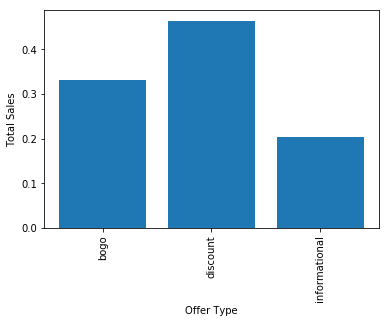

In [364]:
fig, ax = plt.subplots()
ax.bar(offer_trans_by_type_pct["offer_type"], offer_trans_by_type_pct["amount"])
ax.set_xticklabels(offer_trans_by_type_pct["offer_type"], rotation = 90)
ax.set_xlabel("Offer Type")
ax.set_ylabel("Total Sales")

In [365]:
# FRMScore_df.head()

In [366]:
# FRMScore_df.groupby("customer_id").agg({"RFMScore":pd.Series.nunique}).reset_index()["RFMScore"].unique()

In [367]:
offer_trans_final_temp_df = offer_trans_port_new_df.merge(profile, on = "customer_id", how="left")

In [368]:
offer_trans_final_temp_df.head()

,customer_id,portfolio_id,amount,offer_type,reward,difficulty,duration,age,became_member_on,gender,income,days_since_member
0,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,8.57,bogo,5,5,5,33.0,2017-04-21,M,72000.0,1275
1,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,22.05,bogo,5,5,7,40.0,2018-01-09,O,57000.0,1012
2,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,17.24,bogo,10,10,5,59.0,2016-03-04,F,90000.0,1688
3,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,10.32,bogo,5,5,7,24.0,2016-11-11,F,60000.0,1436
4,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,14.53,bogo,5,5,5,24.0,2016-11-11,F,60000.0,1436


In [369]:
# offer_trans_final_temp_df = offer_trans_final_temp_df.merge(FRMScore_df, how = "left", on = "customer_id")

In [370]:
offer_trans_final_df = offer_trans_final_temp_df.drop(columns = ["portfolio_id", "customer_id"])

In [371]:
offer_trans_final_df.head()

,amount,offer_type,reward,difficulty,duration,age,became_member_on,gender,income,days_since_member
0,8.57,bogo,5,5,5,33.0,2017-04-21,M,72000.0,1275
1,22.05,bogo,5,5,7,40.0,2018-01-09,O,57000.0,1012
2,17.24,bogo,10,10,5,59.0,2016-03-04,F,90000.0,1688
3,10.32,bogo,5,5,7,24.0,2016-11-11,F,60000.0,1436
4,14.53,bogo,5,5,5,24.0,2016-11-11,F,60000.0,1436


In [372]:
offer_trans_by_gender_pct = offer_trans_final_df.groupby("gender")["amount"].sum()/offer_trans_final_df["amount"].sum()

Text(0,0.5,'Total Sales')

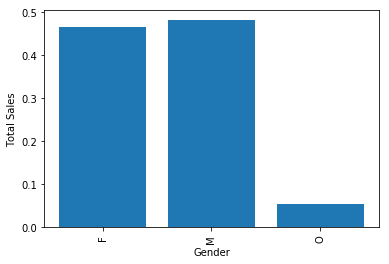

In [373]:
fig, ax = plt.subplots()
ax.bar(offer_trans_by_gender_pct.index, offer_trans_by_gender_pct.values)
ax.set_xticklabels(offer_trans_by_gender_pct.index, rotation = 90)
ax.set_xlabel("Gender")
ax.set_ylabel("Total Sales")

In [374]:
offer_trans_by_age_pct = offer_trans_final_df.groupby("age")["amount"].sum()/offer_trans_final_df["amount"].sum()

Text(0,0.5,'Total Sales')

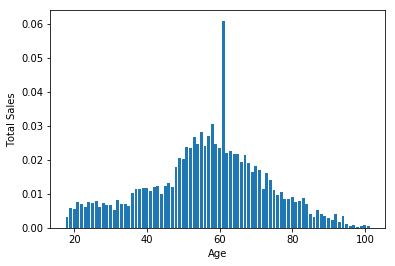

In [375]:
fig, ax = plt.subplots()
ax.bar(offer_trans_by_age_pct.index, offer_trans_by_age_pct.values)
ax.set_xlabel("Age")
ax.set_ylabel("Total Sales")

In [376]:
offer_trans_final_df.head()

,amount,offer_type,reward,difficulty,duration,age,became_member_on,gender,income,days_since_member
0,8.57,bogo,5,5,5,33.0,2017-04-21,M,72000.0,1275
1,22.05,bogo,5,5,7,40.0,2018-01-09,O,57000.0,1012
2,17.24,bogo,10,10,5,59.0,2016-03-04,F,90000.0,1688
3,10.32,bogo,5,5,7,24.0,2016-11-11,F,60000.0,1436
4,14.53,bogo,5,5,5,24.0,2016-11-11,F,60000.0,1436


[Text(0,0,'amount'),
 Text(0,0,'reward'),
 Text(0,0,'difficulty'),
 Text(0,0,'duration'),
 Text(0,0,'age'),
 Text(0,0,'income'),
 Text(0,0,'days_since_member')]

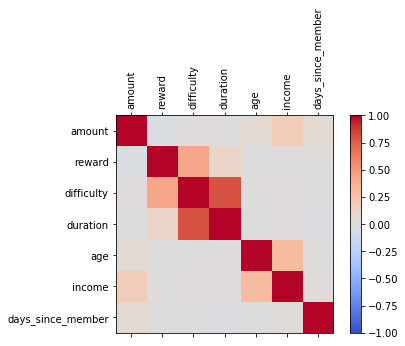

In [377]:
corr = offer_trans_final_df.corr()
fig, ax = plt.subplots()
# ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(offer_trans_final_df.corr().columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(offer_trans_final_df.corr().columns)
ax.set_yticklabels(offer_trans_final_df.corr().columns)

difficulty has week correlation with reward and strong relation with duration. Drop difficulty column

In [378]:
offer_trans_final_df.drop(columns =["difficulty"], inplace=True)

[Text(0,0,'amount'),
 Text(0,0,'reward'),
 Text(0,0,'duration'),
 Text(0,0,'age'),
 Text(0,0,'income'),
 Text(0,0,'days_since_member')]

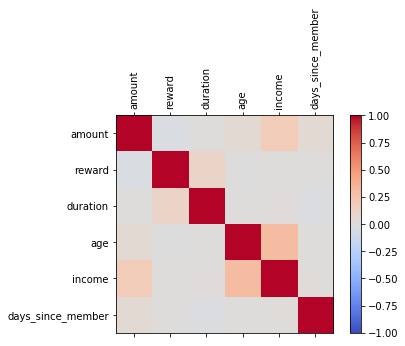

In [379]:
corr = offer_trans_final_df.corr()
fig, ax = plt.subplots()
# ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(offer_trans_final_df.corr().columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(offer_trans_final_df.corr().columns)
ax.set_yticklabels(offer_trans_final_df.corr().columns)

In [380]:
offer_trans_final_df.head()

,amount,offer_type,reward,duration,age,became_member_on,gender,income,days_since_member
0,8.57,bogo,5,5,33.0,2017-04-21,M,72000.0,1275
1,22.05,bogo,5,7,40.0,2018-01-09,O,57000.0,1012
2,17.24,bogo,10,5,59.0,2016-03-04,F,90000.0,1688
3,10.32,bogo,5,7,24.0,2016-11-11,F,60000.0,1436
4,14.53,bogo,5,5,24.0,2016-11-11,F,60000.0,1436


Generate a df for clustering analysis

In [381]:
offer_trans_final_kmeans_df = offer_trans_final_df[["amount", "offer_type", "gender", "age", "days_since_member"]]

In [382]:
offer_trans_final_kmeans_final_df = pd.concat([offer_trans_final_kmeans_df, pd.get_dummies(offer_trans_final_kmeans_df[["offer_type","gender"]])], axis=1)

In [383]:
offer_trans_final_kmeans_final_df.head()

,amount,offer_type,gender,age,days_since_member,offer_type_bogo,offer_type_discount,offer_type_informational,gender_F,gender_M,gender_O
0,8.57,bogo,M,33.0,1275,1,0,0,0,1,0
1,22.05,bogo,O,40.0,1012,1,0,0,0,0,1
2,17.24,bogo,F,59.0,1688,1,0,0,1,0,0
3,10.32,bogo,F,24.0,1436,1,0,0,1,0,0
4,14.53,bogo,F,24.0,1436,1,0,0,1,0,0


In [384]:
offer_trans_final_kmeans_final_df.drop(columns=["offer_type","gender"], inplace=True)

In [385]:
offer_trans_final_kmeans_final_df.head()

,amount,age,days_since_member,offer_type_bogo,offer_type_discount,offer_type_informational,gender_F,gender_M,gender_O
0,8.57,33.0,1275,1,0,0,0,1,0
1,22.05,40.0,1012,1,0,0,0,0,1
2,17.24,59.0,1688,1,0,0,1,0,0
3,10.32,24.0,1436,1,0,0,1,0,0
4,14.53,24.0,1436,1,0,0,1,0,0


In [386]:
offer_trans_final_kmeans_final_norm_df = offer_trans_final_kmeans_final_df.copy()

In [387]:
offer_trans_final_kmeans_final_norm_df.head()

,amount,age,days_since_member,offer_type_bogo,offer_type_discount,offer_type_informational,gender_F,gender_M,gender_O
0,8.57,33.0,1275,1,0,0,0,1,0
1,22.05,40.0,1012,1,0,0,0,0,1
2,17.24,59.0,1688,1,0,0,1,0,0
3,10.32,24.0,1436,1,0,0,1,0,0
4,14.53,24.0,1436,1,0,0,1,0,0


In [388]:
distortions = []
K = range(1,10)
for k in K:
    scaler = StandardScaler()
    kmeans = KMeans(n_clusters=k)
    pipeline = make_pipeline(scaler, kmeans)
    pipeline.fit(offer_trans_final_kmeans_final_norm_df)  
    distortions.append(kmeans.inertia_)

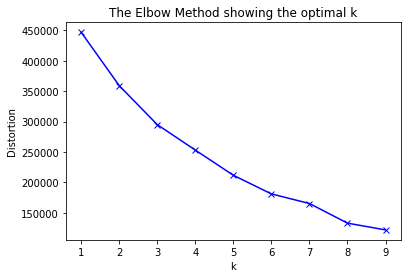

In [389]:
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [390]:
scaler = StandardScaler()
kmeans = KMeans(n_clusters=3)
pipeline = make_pipeline(scaler, kmeans)
pipeline.fit(offer_trans_final_kmeans_final_norm_df)
offer_trans_final_kmeans_final_norm_df['labels'] = kmeans.labels_

In [391]:
offer_trans_final_kmeans_final_norm_df.groupby('labels').count()

,amount,age,days_since_member,offer_type_bogo,offer_type_discount,offer_type_informational,gender_F,gender_M,gender_O
labels,,,,,,,,,
0,8649,8649,8649,8649,8649,8649,8649,8649,8649
1,22609,22609,22609,22609,22609,22609,22609,22609,22609
2,18408,18408,18408,18408,18408,18408,18408,18408,18408


In [392]:
offer_trans_final_kmeans_final_norm_df.groupby('labels').\
agg({"amount":sum, "age":np.mean, "days_since_member":np.mean,\
     "offer_type_bogo":sum, "offer_type_discount":sum, "offer_type_informational":sum,\
     "gender_F":sum, "gender_M":sum, "gender_O":sum
    })

,amount,age,days_since_member,offer_type_bogo,offer_type_discount,offer_type_informational,gender_F,gender_M,gender_O
labels,,,,,,,,,
0,210286.72,54.831426,1374.231125,0.0,0.0,8649.0,3121.0,4406.0,1122.0
1,477179.18,54.858508,1351.643859,0.0,22609.0,0.0,8132.0,11449.0,3028.0
2,340634.85,54.763744,1365.967949,18408.0,0.0,0.0,6653.0,9249.0,2506.0


Clustering Analysis can't tell me what types of customers are preferred what offer. Use collaborative filtering to build a recommendation engine?

Get the info of users who don't have have offers

In [393]:
non_offer_trans_final_df.head()

,customer_id,time,amount
12914,ad18ad432f5a40c7b8ccce4be4fb530c,0,17.00
13091,be01dde700574797b5dc59b0ad45242f,0,11.62
13117,3f7ac208f7e844cab207ceb8e42177ba,0,0.23
13202,d08a73ea06f441009a2710c5cb2f6327,0,8.55
13213,08579355f46b49efa8412ddacc4ac832,0,24.72


In [394]:
offer_non_trans_port_new_df = non_offer_trans_final_df.\
merge(profile,on = "customer_id", how = "left")

In [395]:
offer_non_trans_port_new_df.head()

,customer_id,time,amount,age,became_member_on,gender,income,days_since_member
0,ad18ad432f5a40c7b8ccce4be4fb530c,0,17.00,51.0,2017-08-11,F,80000.0,1163
1,be01dde700574797b5dc59b0ad45242f,0,11.62,79.0,2016-02-09,F,55000.0,1712
2,3f7ac208f7e844cab207ceb8e42177ba,0,0.23,61.0,2018-05-08,O,NaN,893
3,d08a73ea06f441009a2710c5cb2f6327,0,8.55,25.0,2017-12-19,M,73000.0,1033
4,08579355f46b49efa8412ddacc4ac832,0,24.72,60.0,2017-08-07,F,87000.0,1167


In [396]:
non_offer_trans_by_gender_pct = offer_non_trans_port_new_df.groupby("gender")["amount"].sum()/offer_non_trans_port_new_df["amount"].sum()

Text(0,0.5,'Total Sales')

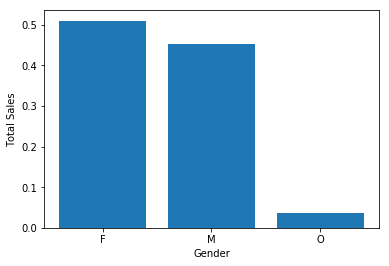

In [397]:
fig, ax = plt.subplots()
ax.bar(non_offer_trans_by_gender_pct.index, non_offer_trans_by_gender_pct.values)
ax.set_xlabel("Gender")
ax.set_ylabel("Total Sales")

In [398]:
non_offer_trans_by_age_pct = offer_non_trans_port_new_df.groupby("age")["amount"].sum()/offer_non_trans_port_new_df["amount"].sum()

Text(0,0.5,'Total Sales')

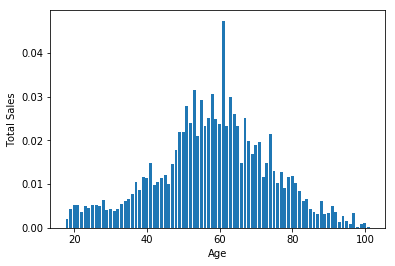

In [399]:
fix, ax = plt.subplots()
ax.bar(non_offer_trans_by_age_pct.index, non_offer_trans_by_age_pct.values)
ax.set_xlabel("Age")
ax.set_ylabel("Total Sales")

# Tree based Prediction Model

In [403]:
profile.head()

,age,became_member_on,gender,customer_id,income,days_since_member
0,61.0,2017-02-12,O,68be06ca386d4c31939f3a4f0e3dd783,NaN,1343
1,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1190
2,61.0,2018-07-12,O,38fe809add3b4fcf9315a9694bb96ff5,NaN,828
3,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1257
4,61.0,2017-08-04,O,a03223e636434f42ac4c3df47e8bac43,NaN,1170


In [483]:
offer_trans_port_new_df.head()

,customer_id,portfolio_id,amount,offer_name,offer_type,reward,difficulty,duration
0,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,8.57,offer_8,bogo,5,5,5
1,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,22.05,offer_3,bogo,5,5,7
2,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,17.24,offer_1,bogo,10,10,5
3,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,10.32,offer_3,bogo,5,5,7
4,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,14.53,offer_8,bogo,5,5,5


In [404]:
# offer_trans_port_final_df = offer_trans_port_new_df.merge(profile, on="customer_id", how="left")\
# [["portfolio_id", "offer_type", "duration", "difficulty", "age", "days_since_member", "gender", "amount"]]

In [487]:
offer_trans_port_final_df = offer_trans_port_new_df.merge(profile, on="customer_id", how="left")\
[["offer_name", "offer_type", "channel_web", "channel_email", "channel_mobile", "channel_social",\
  "age", "days_since_member", "gender", "amount"]]

In [488]:
offer_trans_port_final_df.head()

,offer_name,offer_type,channel_web,channel_email,channel_mobile,channel_social,age,days_since_member,gender,amount
0,offer_8,bogo,1,1,1,1,33.0,1275,M,8.57
1,offer_3,bogo,1,1,1,0,40.0,1012,O,22.05
2,offer_1,bogo,1,1,1,1,59.0,1688,F,17.24
3,offer_3,bogo,1,1,1,0,24.0,1436,F,10.32
4,offer_8,bogo,1,1,1,1,24.0,1436,F,14.53


In [489]:
offer_non_trans_port_new_df.head()

,customer_id,time,amount,age,became_member_on,gender,income,days_since_member,offer_type,portfolio_id,offer_name
0,ad18ad432f5a40c7b8ccce4be4fb530c,0,17.00,51.0,2017-08-11,F,80000.0,1163,no,0,None
1,be01dde700574797b5dc59b0ad45242f,0,11.62,79.0,2016-02-09,F,55000.0,1712,no,0,None
2,3f7ac208f7e844cab207ceb8e42177ba,0,0.23,61.0,2018-05-08,O,NaN,893,no,0,None
3,d08a73ea06f441009a2710c5cb2f6327,0,8.55,25.0,2017-12-19,M,73000.0,1033,no,0,None
4,08579355f46b49efa8412ddacc4ac832,0,24.72,60.0,2017-08-07,F,87000.0,1167,no,0,None


In [490]:
offer_non_trans_port_new_df["offer_type"] = "no"
# offer_non_trans_port_new_df["duration"] = 0
# offer_non_trans_port_new_df["difficulty"] = 0
offer_non_trans_port_new_df["portfolio_id"] = "0"
offer_non_trans_port_new_df["offer_name"] = "None"
offer_non_trans_port_new_df["channel_web"] = 0
offer_non_trans_port_new_df["channel_email"] = 0
offer_non_trans_port_new_df["channel_mobile"] = 0
offer_non_trans_port_new_df["channel_social"] = 0

In [419]:
offer_non_trans_port_new_df.head()

,customer_id,time,amount,age,became_member_on,gender,income,days_since_member,offer_type,portfolio_id,offer_name
0,ad18ad432f5a40c7b8ccce4be4fb530c,0,17.00,51.0,2017-08-11,F,80000.0,1163,no,0,None
1,be01dde700574797b5dc59b0ad45242f,0,11.62,79.0,2016-02-09,F,55000.0,1712,no,0,None
2,3f7ac208f7e844cab207ceb8e42177ba,0,0.23,61.0,2018-05-08,O,NaN,893,no,0,None
3,d08a73ea06f441009a2710c5cb2f6327,0,8.55,25.0,2017-12-19,M,73000.0,1033,no,0,None
4,08579355f46b49efa8412ddacc4ac832,0,24.72,60.0,2017-08-07,F,87000.0,1167,no,0,None


In [ ]:
# offer_non_trans_port_final_df = offer_non_trans_port_new_df[["portfolio_id", "offer_type", "duration", "difficulty",\
#                                                              "age", "days_since_member", "gender", "amount"]]

In [491]:
offer_non_trans_port_final_df = offer_non_trans_port_new_df[["offer_name", "offer_type","channel_web", "channel_email", "channel_mobile", "channel_social",\
                                                             "age", "days_since_member", "gender", "amount"]]

In [492]:
customer_offer_tree = pd.concat([offer_trans_port_final_df, offer_non_trans_port_final_df])

In [493]:
customer_offer_tree.head()

,offer_name,offer_type,channel_web,channel_email,channel_mobile,channel_social,age,days_since_member,gender,amount
0,offer_8,bogo,1,1,1,1,33.0,1275,M,8.57
1,offer_3,bogo,1,1,1,0,40.0,1012,O,22.05
2,offer_1,bogo,1,1,1,1,59.0,1688,F,17.24
3,offer_3,bogo,1,1,1,0,24.0,1436,F,10.32
4,offer_8,bogo,1,1,1,1,24.0,1436,F,14.53


In [ ]:
# customer_offer_final_tree = pd.concat([customer_offer_tree, pd.get_dummies(customer_offer_tree[["offer_type", "gender", "duration", "difficulty"]])], axis = 1)

In [494]:
customer_offer_final_tree = pd.concat([customer_offer_tree, pd.get_dummies(customer_offer_tree[["offer_type", "gender"]])], axis = 1)

In [ ]:
# customer_offer_final_tree.drop(columns = ["offer_type", "duration", "difficulty", "gender"], inplace = True)

In [495]:
customer_offer_final_tree.drop(columns = ["offer_type", "gender"], inplace = True)

In [ ]:
# customer_offer_final_tree.loc[:, ~customer_offer_final_tree.columns.isin(["portfolio_id", "age", "days_since_member", "amount"])] = \
# customer_offer_final_tree.loc[:, ~customer_offer_final_tree.columns.isin(["portfolio_id", "age", "days_since_member", "amount"])].astype('bool')

In [496]:
customer_offer_final_tree.head()

,offer_name,channel_web,channel_email,channel_mobile,channel_social,age,days_since_member,amount,offer_type_bogo,offer_type_discount,offer_type_informational,offer_type_no,gender_F,gender_M,gender_O
0,offer_8,1,1,1,1,33.0,1275,8.57,1,0,0,0,0,1,0
1,offer_3,1,1,1,0,40.0,1012,22.05,1,0,0,0,0,0,1
2,offer_1,1,1,1,1,59.0,1688,17.24,1,0,0,0,1,0,0
3,offer_3,1,1,1,0,24.0,1436,10.32,1,0,0,0,1,0,0
4,offer_8,1,1,1,1,24.0,1436,14.53,1,0,0,0,1,0,0


## Offer Type Classification

In [497]:
y_clf = customer_offer_final_tree["offer_name"]
X_clf = customer_offer_final_tree.drop(columns = ["offer_name"])

In [498]:
X_clf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85819 entries, 0 to 36152
Data columns (total 14 columns):
channel_web                 85819 non-null int64
channel_email               85819 non-null int64
channel_mobile              85819 non-null int64
channel_social              85819 non-null int64
age                         85819 non-null float64
days_since_member           85819 non-null int64
amount                      85819 non-null float64
offer_type_bogo             85819 non-null uint8
offer_type_discount         85819 non-null uint8
offer_type_informational    85819 non-null uint8
offer_type_no               85819 non-null uint8
gender_F                    85819 non-null uint8
gender_M                    85819 non-null uint8
gender_O                    85819 non-null uint8
dtypes: float64(2), int64(5), uint8(7)
memory usage: 5.8 MB


In [499]:
SEED = 123

In [500]:
X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(X_clf, y_clf, test_size=0.3, random_state=SEED)

In [522]:
dt_gini = DecisionTreeClassifier(max_depth=6, min_samples_leaf=1000, random_state=SEED)

In [523]:
dt_gini.fit(X_clf_train, y_clf_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1000, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=123,
            splitter='best')

In [524]:
y_gini_pred = dt_gini.predict(X_clf_test)

In [525]:
accuracy_gini = accuracy_score(y_clf_test, y_gini_pred)
print("Test set accuracy: {:.2f}".format(accuracy_gini))

Test set accuracy: 0.89


In [526]:
FEATURE_NAMES = X_clf_test.columns

In [527]:
CLASS_NAMES = y_clf_test.unique()

In [528]:
export_graphviz(dt_gini
                , 'gini_tree.dot'
                , feature_names = FEATURE_NAMES
                , class_names = CLASS_NAMES
               )

In [529]:
! dot -Tpng gini_tree.dot -o gini_tree.png

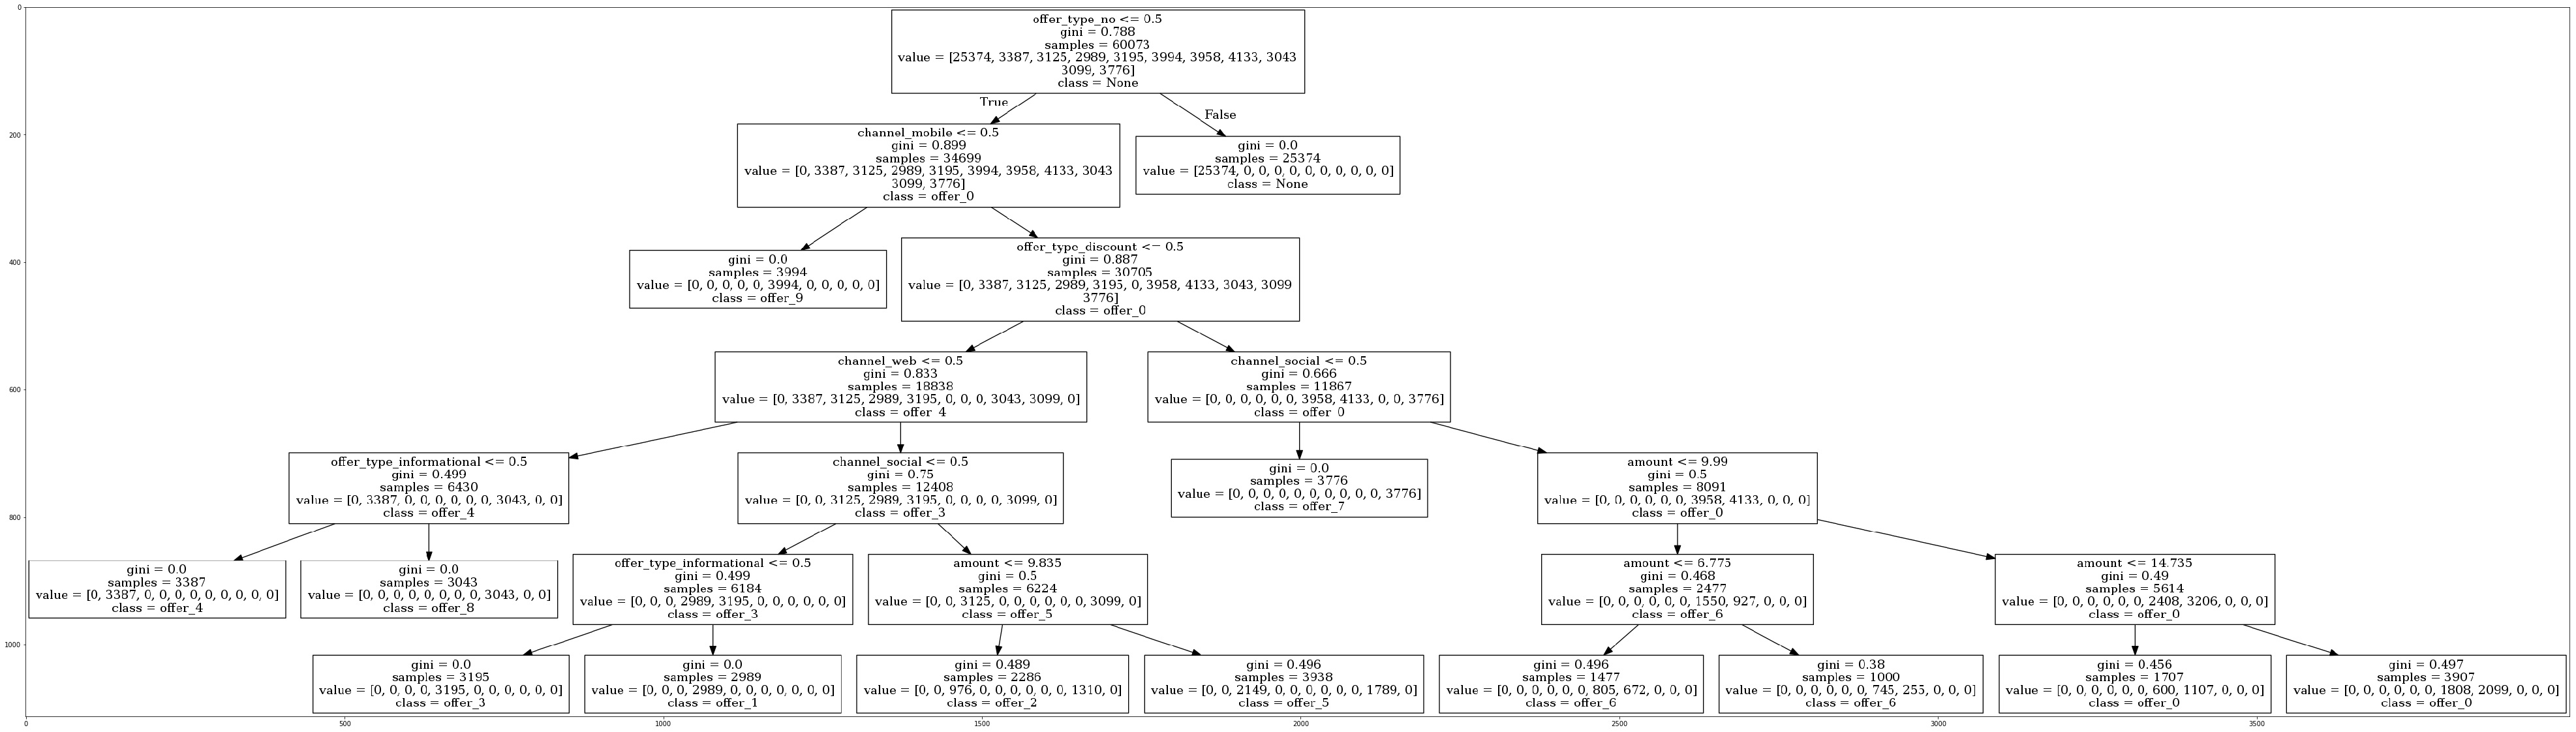

In [530]:
img = cv2.imread('gini_tree.png')
plt.figure(figsize = (100, 20))
plt.imshow(img)

In [531]:
dt_entropy = DecisionTreeClassifier(max_depth=6,  min_samples_leaf=2000, criterion='entropy', random_state=SEED)

In [532]:
dt_entropy.fit(X_clf_train, y_clf_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2000, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=123,
            splitter='best')

In [533]:
y_entropy_pred = dt_entropy.predict(X_clf_test)

In [534]:
accuracy_entropy = accuracy_score(y_clf_test, y_entropy_pred)
print('Accuracy achieved by using entropy: {:.2f}'.format(accuracy_entropy))

Accuracy achieved by using entropy: 0.89


In [535]:
export_graphviz(dt_entropy, 'entropy_tree.dot', feature_names = FEATURE_NAMES
                , class_names = CLASS_NAMES
                , filled = True
                , rounded = True)

In [536]:
! dot -Tpng entropy_tree.dot -o entropy_tree.png

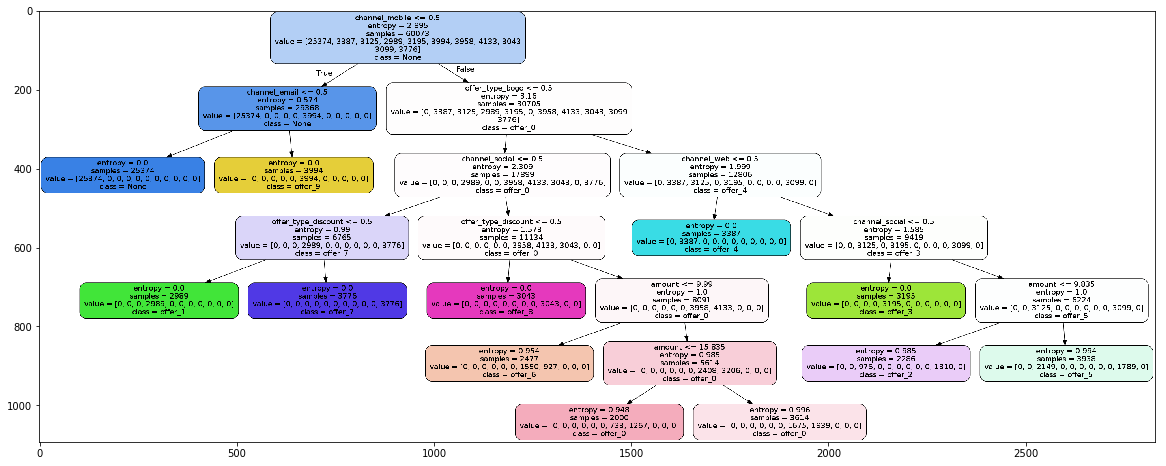

In [537]:
img2 = cv2.imread('entropy_tree.png')
plt.figure(figsize = (20, 20))
plt.imshow(img2)

## Interpret Results

In [ ]:
y_entropy_pred

In [ ]:
entropy_pred_df = pd.DataFrame(y_entropy_pred, columns = ["entropy_pred_offer"])

In [ ]:
entropy_pred_df["entropy_pred_offer"].value_counts()

In [ ]:
entropy_pred_df["entropy_pred_offer"].value_counts()/entropy_pred_df["entropy_pred_offer"].shape[0]

In [ ]:
customer_offer_tree["offer_type"].value_counts()

In [ ]:
customer_offer_tree["offer_type"].value_counts()/customer_offer_tree["offer_type"].shape[0]

In [ ]:
customer_offer_final_tree.head()

## Amount Regression

In [ ]:
customer_offer_final_reg_tree = pd.concat([customer_offer_final_tree,\
                                           pd.get_dummies(customer_offer_final_tree["offer_type"])], axis = 1)

In [ ]:
customer_offer_final_reg_tree.drop(columns=["offer_type"], inplace=True)

In [ ]:
customer_offer_final_reg_tree[["bogo", "discount", "informational", "no"]] =\
customer_offer_final_reg_tree[["bogo", "discount", "informational", "no"]].astype("bool")

In [ ]:
y_reg = customer_offer_final_reg_tree["amount"]
X_reg = customer_offer_final_reg_tree.drop(columns = ["amount"])

In [ ]:
Seed = 321

In [ ]:
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.3, random_state=Seed)

In [ ]:
dt_reg = DecisionTreeRegressor(max_depth=8,
             min_samples_leaf=0.13,
            random_state=3)

In [ ]:
X_reg_train.head()

In [ ]:
dt_reg.fit(X_reg_train, y_reg_train)

In [ ]:
y_reg_pred = dt_reg.predict(X_reg_test)

# Compute mse_dt
mse_reg_dt = MSE(y_reg_test, y_reg_pred)

# Compute rmse_dt
rmse_reg_dt = mse_reg_dt**(1/2)

# Print rmse_dt
print("Test set RMSE of dt: {:.2f}".format(rmse_reg_dt))

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
lr = LinearRegression()

In [ ]:
lr.fit(X_reg_train, y_reg_train)

In [ ]:
y_pred_lr = lr.predict(X_reg_test)

# Compute mse_lr
mse_lr = MSE(y_reg_test, y_pred_lr)

# Compute rmse_lr
rmse_lr = mse_lr**(1/2)
print("Test set RMSE of dt: {:.2f}".format(rmse_lr))

# TODOs: Validate the data

# Build Cllaborative Filtering Engine

In [ ]:
# display(offer_non_trans_port_new_df.head())
# offer_trans_port_new_df.head()

In [ ]:
#Create customer-by-offer df
# customer_offer = pd.concat([offer_trans_port_new_df[["customer_id", "portfolio_id", "amount"]],\
#                         offer_non_trans_port_new_df[["customer_id", "portfolio_id", "amount"]]])

In [ ]:
# customer_offer.head()

In [ ]:
# customer_offer_matrix = customer_offer.groupby(["customer_id", "portfolio_id"])["amount"].sum().unstack()

In [ ]:
# customer_offer_matrix.fillna(0, inplace=True)

In [ ]:
# customer_offer_matrix.head()

In [ ]:
def offers_received(customer_id):
    '''
    INPUT:
    customer_id - the customer_id of a customer as string
    OUTPUT:
    offers - an array of offers the customer received
    '''
    
    offers = customer_offer_matrix.loc[customer_id][customer_offer_matrix.loc[customer_id].isnull() == False].index.values
    
    return offers

In [ ]:
def create_offers_to_analyze():
    '''
    INPUT: None
    OUTPUT: offers_received - a dictionary where each key is a customer_id and the value is an array of portfolio_ids
    
    Creates the offers_received dictionary
    '''
    n_customers = customer_offer_matrix.shape[0]
    customers = customer_offer_matrix.index
    offers_received_dict = dict()
    
    cnter = 0
    bar = progressbar.ProgressBar(maxval=n_customers+1, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    
    for customer in range(1, n_customers+1):
        
        cnter+=1
        bar.update(cnter)
        
        customer_id = customers[customer-1]
        
        offers_received_dict[customer_id] = offers_received(customer_id)
    
    bar.finish()
    
    return offers_received_dict

In [ ]:
# offers_to_analyze = create_offers_to_analyze()

In [ ]:
def compute_euclidean_dist(customer1, customer2):
    '''
    INPUT
    customer1 - str customer id
    customer2 - str customer id
    OUTPUT
    the correlation between the matching ratings between the two users
    '''
    
    offer1 = offers_to_analyze[customer1]
    offer2 = offers_to_analyze[customer2]
    
    sim_offers = np.intersect1d(offer1, offer2, assume_unique=True)
    
    df = customer_offer_matrix.loc[(customer1, customer2), sim_offers]
    dist = np.linalg.norm(df.loc[customer1] - df.loc[customer2])
    
    return dist

In [ ]:
def customers_dists(customer_id):
    '''
    INPUT:
    customer_id - str customer_id
    
    OUTPUT:
    the distance between the inputed customer and other customers
    '''
    
    customers = customer_offer_matrix.index
    customers = customers.drop(customer_id)
    customer1,  customer2, eucl_dist= [], [], []
    
    center = 0
    bar = progressbar.ProgressBar(maxval=len(customers)+1, widgets=[progressbar.Bar('*', '{', '}'), ' ', progressbar.Percentage()])
    bar.start()

    for customer in customers:
        center +=1
        bar.update(center)
        
        customer1.append(customer_id)
        customer2.append(customer)
        eucl_dist.append(compute_euclidean_dist(customer_id, customer))

    bar.finish()
    
    customer_dists_df = pd.DataFrame({'customer1':customer1,'customer2':customer2,'eucl_dist':eucl_dist})
    
    return customer_dists_df 

In [ ]:
customer_id_test = '0011e0d4e6b944f998e987f904e8c1e5'

In [ ]:
# customer_offer_df_test = customers_dists(customer_id_test)

In [ ]:
# customer_offer_df_test.head()

In [ ]:
def find_closest_neighbors(customer_id):
    '''
    INPUT:
        customer_id - (str) the customer_id of the individual customer you want to find the closest heighbors
    OUTPUT:
        closest_neighbors - an array of the customer_id's of the customer sorted from closest to farthest way
    '''
    
    dists_df = customers_dists(customer_id)
    closest_customers = dists_df.sort_values(by='eucl_dist').iloc[1:]['customer2']
    closest_neighbors = np.array(closest_customers)
    
    return closest_neighbors

In [ ]:
transcript.loc[transcript["amount"]>0, "amount"].describe()

In [ ]:
# customer_offer.head()

In [ ]:
def offers_liked(customer_id, min_spending=1.0):
    '''
    INPUT:
    customer_id - (str) the customer_id of an individual
    min_spending - (float) the minimum spending considered while still a "like"

    OUTPUT:
    offers_liked - an array of offers the customer has liked
    '''
    offers_liked = np.array(customer_offer.query("customer_id == @customer_id and amount > (@min_spending-1)")["portfolio_id"])

    return offers_liked

In [ ]:
portfolio.head()

In [ ]:
def offer_type(offer_ids):
    '''
    INPUT
    offers_ids: a list of offer_ids
    OUTPUT
    offer_type: a list of offer types associated with the offer_ids
    '''
    
    offer_lst = list(portfolio[portfolio["portfolio_id"].isin(offer_ids)]["offer_type"].unique())
    
    if '0' in offer_ids:
        offer_lst.append('no offers')
    else:
        offer_lst
        
    return offer_lst

In [ ]:
def make_recommendations(customer_id, num_recs = 3):
    '''
    INPUT:
    customer_id - (str) a customer_id of the individual want to make recommendations for
    num_recs - (int) number of offers to return
    
    OUTPUT:
    recommendations - a list of offer types
    '''
    offers_got = offers_received(customer_id)
    closest_neighbors = find_closest_neighbors(customer_id)
    
    recs = np.array([])
    
    center = 0
    bar = progressbar.ProgressBar(maxval=len(closest_neighbors)+1, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    
    for neighbor in closest_neighbors:
        center +=1
        bar.update(center)
        
        neighbs_likes = offers_liked(neighbor)
        
        new_recs = np.setdiff1d(neighbs_likes, offers_got, assume_unique=True)
        
        recs = np.unique(np.concatenate([new_recs, recs], axis=0))
        
        if len(recs) > num_recs-1:
            break
    
    bar.finish()
    
    recommendations = offer_type(recs)
    
    return recommendations

In [ ]:
# make_recommendations(customer_id_test)